#### Setup in Paperspace

In [1]:
%pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.7 MB/s eta 0:00:00


In [69]:
%pip install matplotlib imageio scikit-learn tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 10.1 MB/s eta 0:00:00


# Data Processing

In [1]:
import math
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
from scipy.stats import multivariate_normal

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.module import Module

import torch_geometric
from torch_geometric.nn import GCNConv

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f'using {device}')

# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  

using cpu


In [110]:
# Antivectorize given vector into adjacency matrix
def antiVectorize(vec, m):
    M = np.zeros((m,m))
    M[np.tril_indices(m,k=-1)] = vec
    M= M.transpose()
    M[np.tril_indices(m,k=-1)] = vec
    return M

# Vectorize graph adjacency matrix into a vector
def vectorize(M):
    return M[np.tril_indices(M.shape[0], k=-1)]

### Load Dataset

#### Load Simulated Dataset

In [3]:
def multivariate_simulate(datapath, n_samples=200,n_time=2,n_views=4):
    # Note that changing the node count is not provided right now, since we use correlation matrix
    # and the mean values of connectivities from real data and it is for 35 nodes.
    
    # Import all required statistical information.
    allstats = np.load(datapath + "stats/REAL_TIME_DIFF.npy") # Connectivity mean values of LH. You can also try with RH.
    allcorrs = np.load(datapath + "stats/REAL_TIME_DIFF.npy") # Correlation matrix in LH. You can also try with RH.
    all_diffs = np.load(datapath + "stats/REAL_TIME_DIFF.npy") # This is an overall representation of time differences in both (LH and RH) datasets.
    
    times = []
    for t in range(n_time):
        views = []
        for v in range(n_views):
            # Note that we randomly assign a new random state to ensure it will generate a different dataset at each run.
            # Generate data with the correlations and mean values at the current timepoint.
            if t < 2:
                connectomic_means = allstats[t,v]
                data = multivariate_normal.rvs(connectomic_means,allcorrs[t,v],n_samples,random_state=randint(1,9999))
            # If the requested timepoints are more than we have in real data, use the correlation information from the last timepoint.
            else:
                connectomic_means = allstats[-1,v]
                data = multivariate_normal.rvs(connectomic_means,allcorrs[-1,v],n_samples,random_state=randint(1,9999))

            adj = []
            for idx, sample in enumerate(data):
                # Create adjacency matrix.
                matrix = antiVectorize(sample,35)
                # Perturb the real time difference with nonlinear tanh function.
                noise = np.tanh( t / n_time )
                # Further timepoints will have more significant difference from the baseline (t=6 >> t=1).
                matrix = matrix + all_diffs[:,:,v] * ( noise + 1 )
                adj.append(matrix)
            views.append(np.array(adj))

        times.append(np.array(views))
    
    alldata=np.array(times)
    alldata = np.transpose(alldata,(2,0,3,4,1))
    return alldata 

def prepare_data(datapath, new_data=False, n_samples=200, n_times=6):
    # Note that data with 200 samples and 6 timepoints is very large (5.8M data points),
    # check your GPU memory to make sure there is enough space to allocate. If not, try:
    # - to reduce dataset size by changing n_samples or n_times.
    # - on CPU (this will allocate memory on RAM) --> This might work for example if you have 1GB GPU memory but 16GB RAM.
    # - on another computer with a better NVIDIA graphics card. --> 2GB GPU memory will not be enough for 5.8M data.
    try:
        if new_data:
            samples = multivariate_simulate(n_samples,n_times)
            np.save(datapath + 'multivariate_simulation_data.npy',samples)
        else:
            samples = np.load(datapath + 'multivariate_simulation_data.npy')
    except:
        samples = multivariate_simulate(n_samples,n_times)
        np.save(datapath + 'multivariate_simulation_data.npy',samples)
    return samples

In [4]:
dataset_path = "/Users/gitaayusalsabila/Documents/0thesis/code/sandbox/dataset/"
# dataset_path = "/notebooks/dataset/"
simulated_data = prepare_data(dataset_path, new_data=False, n_samples=100, n_times=3)
simulated_data.shape

(100, 3, 35, 35, 4)

# Pre-processing and Cleansing

In [5]:
# dataset declaration
dataset = simulated_data
num_graphs, num_timepoints, num_nodes, _, num_domains = dataset.shape

### Negative and NaN values cleansing

In [6]:
def data_cleansing(dataset):
    # Replace negative values with 0
    dataset[dataset < 0] = 0
    
    # Replace NaN values with 0
    dataset = np.nan_to_num(dataset, nan=0)
    
    return dataset

In [7]:
dataset_cleaned = data_cleansing(dataset)
dataset_cleaned.shape

(100, 3, 35, 35, 4)

### PCA

In [62]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def pca_variance_analysis(flattened_data, domain, threshold=0.95):
    # Perform PCA
    pca = PCA()
    pca.fit(flattened_data)

    # Explained variance
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(explained_variance, marker='o', linestyle='--')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'Explained Variance vs. Number of Principal Components for Domain {domain}')
    plt.grid(True)
    plt.show()

    num_components = np.argmax(explained_variance >= threshold) + 1

    print(f'Number of principal components to capture {threshold * 100}% variance: {num_components}')
    return num_components

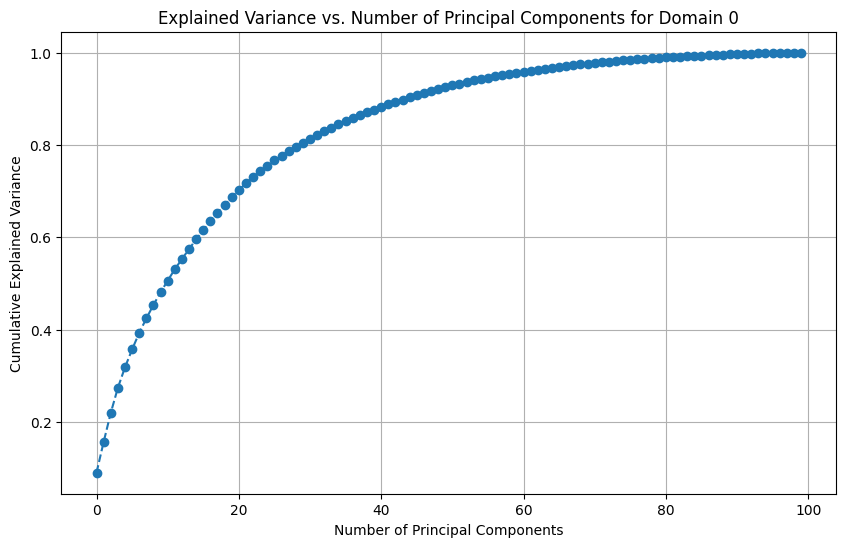

Number of principal components to capture 95.0% variance: 58


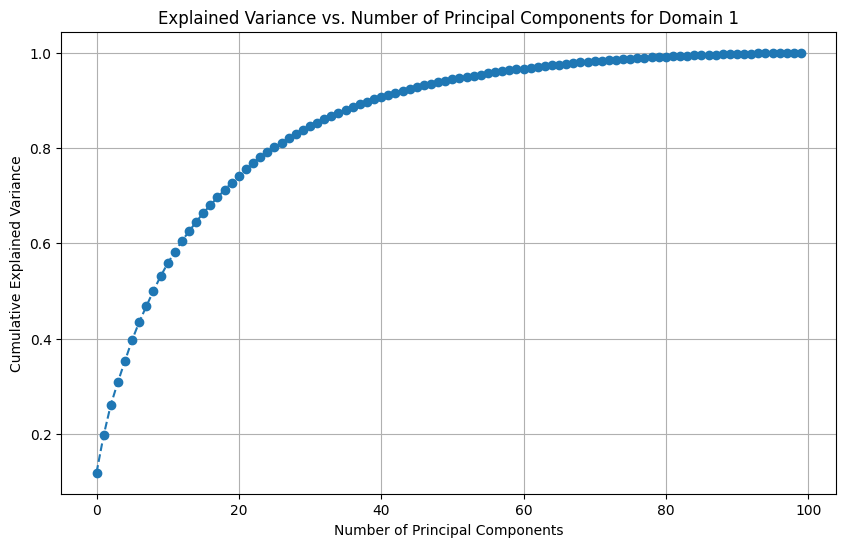

Number of principal components to capture 95.0% variance: 54


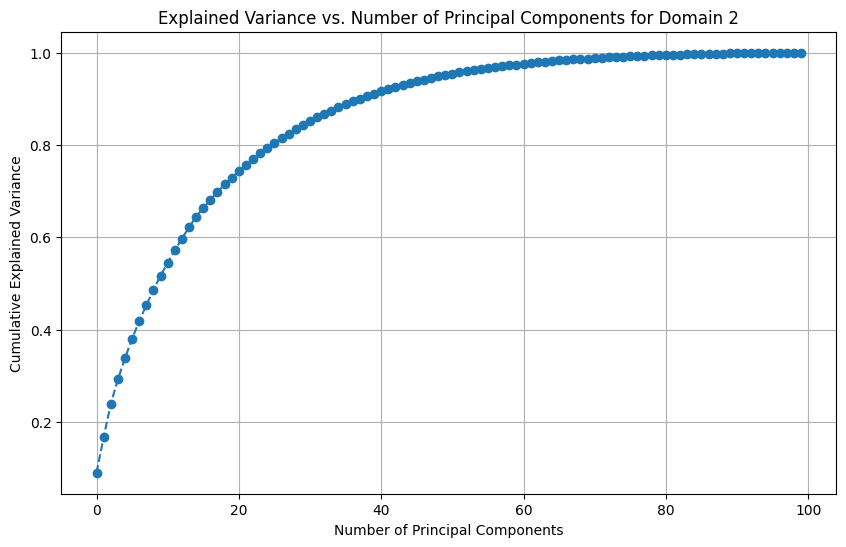

Number of principal components to capture 95.0% variance: 50


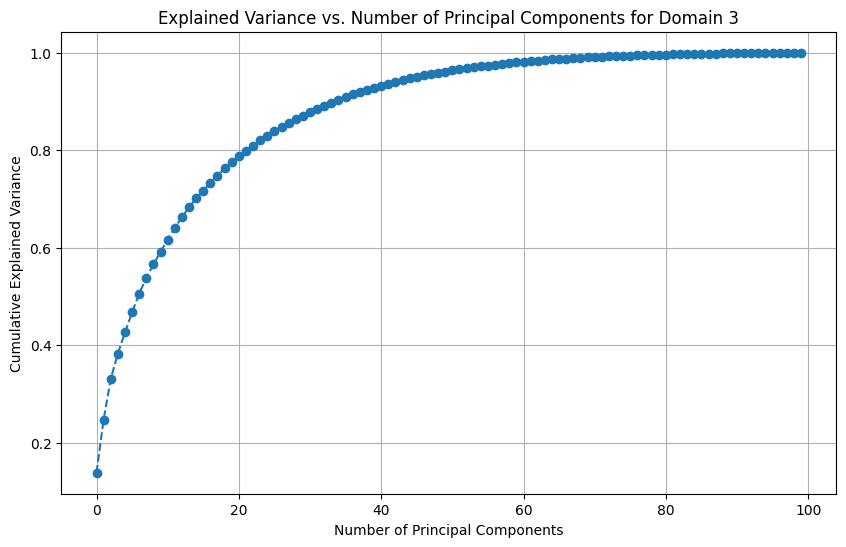

Number of principal components to capture 95.0% variance: 46
Mean of The number of Principal Components with the Highest Variance:  52.0


In [64]:
num_pca_components = []
for d in range(4):
    adjacency_train_set = dataset_cleaned[:,:,:,:,d]

    # Reshape and flatten the data
    num_graphs, num_time_points, num_nodes, _ = adjacency_train_set.shape
    flattened_data = adjacency_train_set.reshape(num_graphs, num_time_points * num_nodes * num_nodes)
    num_pca_components.append(pca_variance_analysis(flattened_data, d))

print("Mean of The number of Principal Components with the Highest Variance: ", np.mean(num_pca_components))

### Node Feature Initialization

In [8]:
from scipy.sparse.linalg import eigsh
from scipy.sparse import csgraph

def laplacian_positional_encoding(adj_matrix, dim):
    laplacian = csgraph.laplacian(adj_matrix, normed=True)
    eigvals, eigvecs = eigsh(laplacian, k=dim + 1, which='SM')
    return torch.tensor(eigvecs[:, 1:], dtype=torch.float)  # Skip the first eigenvector

def node_feature_initialization(graphs, num_graphs, num_timepoints, num_domains, num_nodes, feature_dim=16):
    node_features = np.zeros((num_graphs, num_timepoints, num_nodes, feature_dim, num_domains))

    for i in range(num_graphs):
        for t in range(num_timepoints):
            for d in range(num_domains):
                adj_matrix = graphs[i, t, :, :, d]
                node_features[i, t, :, :, d] = laplacian_positional_encoding(adj_matrix, feature_dim)
    return node_features

In [9]:
node_features = node_feature_initialization(dataset_cleaned, num_graphs, num_timepoints, num_domains, num_nodes)
node_features.shape

(100, 3, 35, 16, 4)

### Graph Normalization

In [13]:
def normalize_adj_matrix(adj):
    # Calculate the degree matrix
    degrees = np.sum(adj, axis=1) # Sum of weights for each node
    degrees[degrees == 0] = 1
    D_hat_inv_sqrt = np.diag(1.0 / np.sqrt(degrees))
    
    # Perform the normalization
    normalized_adj = D_hat_inv_sqrt.dot(adj).dot(D_hat_inv_sqrt)
    
    return normalized_adj

def normalize_graph_dataset(dataset):
    normalized_dataset = np.zeros_like(dataset)
    num_graphs, num_timepoints, _, _, num_domain = dataset.shape
    
    for i in range(num_graphs):
        for t in range(num_timepoints):
            for d in range(num_domain):
                adjacency_matrix = dataset[i, t, :, :, d]
                normalized_adjacency_matrix = normalize_adj_matrix(adjacency_matrix)
                normalized_dataset[i, t, :, :, d] = normalized_adjacency_matrix
    
    return normalized_dataset

In [12]:
dataset_normalized = normalize_graph_dataset(dataset_cleaned)
dataset_normalized.shape

(100, 3, 35, 35, 4)

### Data Visualization (checking)

In [13]:
# Visualizing Adjacency Matrices for Each Graph, Time Point, and View
def plot_heatmaps(X, num_samples=3):
    num_graphs, num_timepoints, num_nodes, _, num_views = X.shape
    fig, axs = plt.subplots(num_samples * num_views, num_timepoints, figsize=(15, 5 * num_samples * num_views))
    
    for i in range(num_samples):
        for v in range(num_views):
            for t in range(num_timepoints):
                ax = axs[i * num_views + v, t]
                sns.heatmap(X[i, t, :, :, v], ax=ax, cmap="YlGnBu")
                ax.set_title(f"Graph {i+1}, View {v+1}, Timepoint {t+1}")
                ax.axis('off')
    
    plt.tight_layout()
    plt.show()

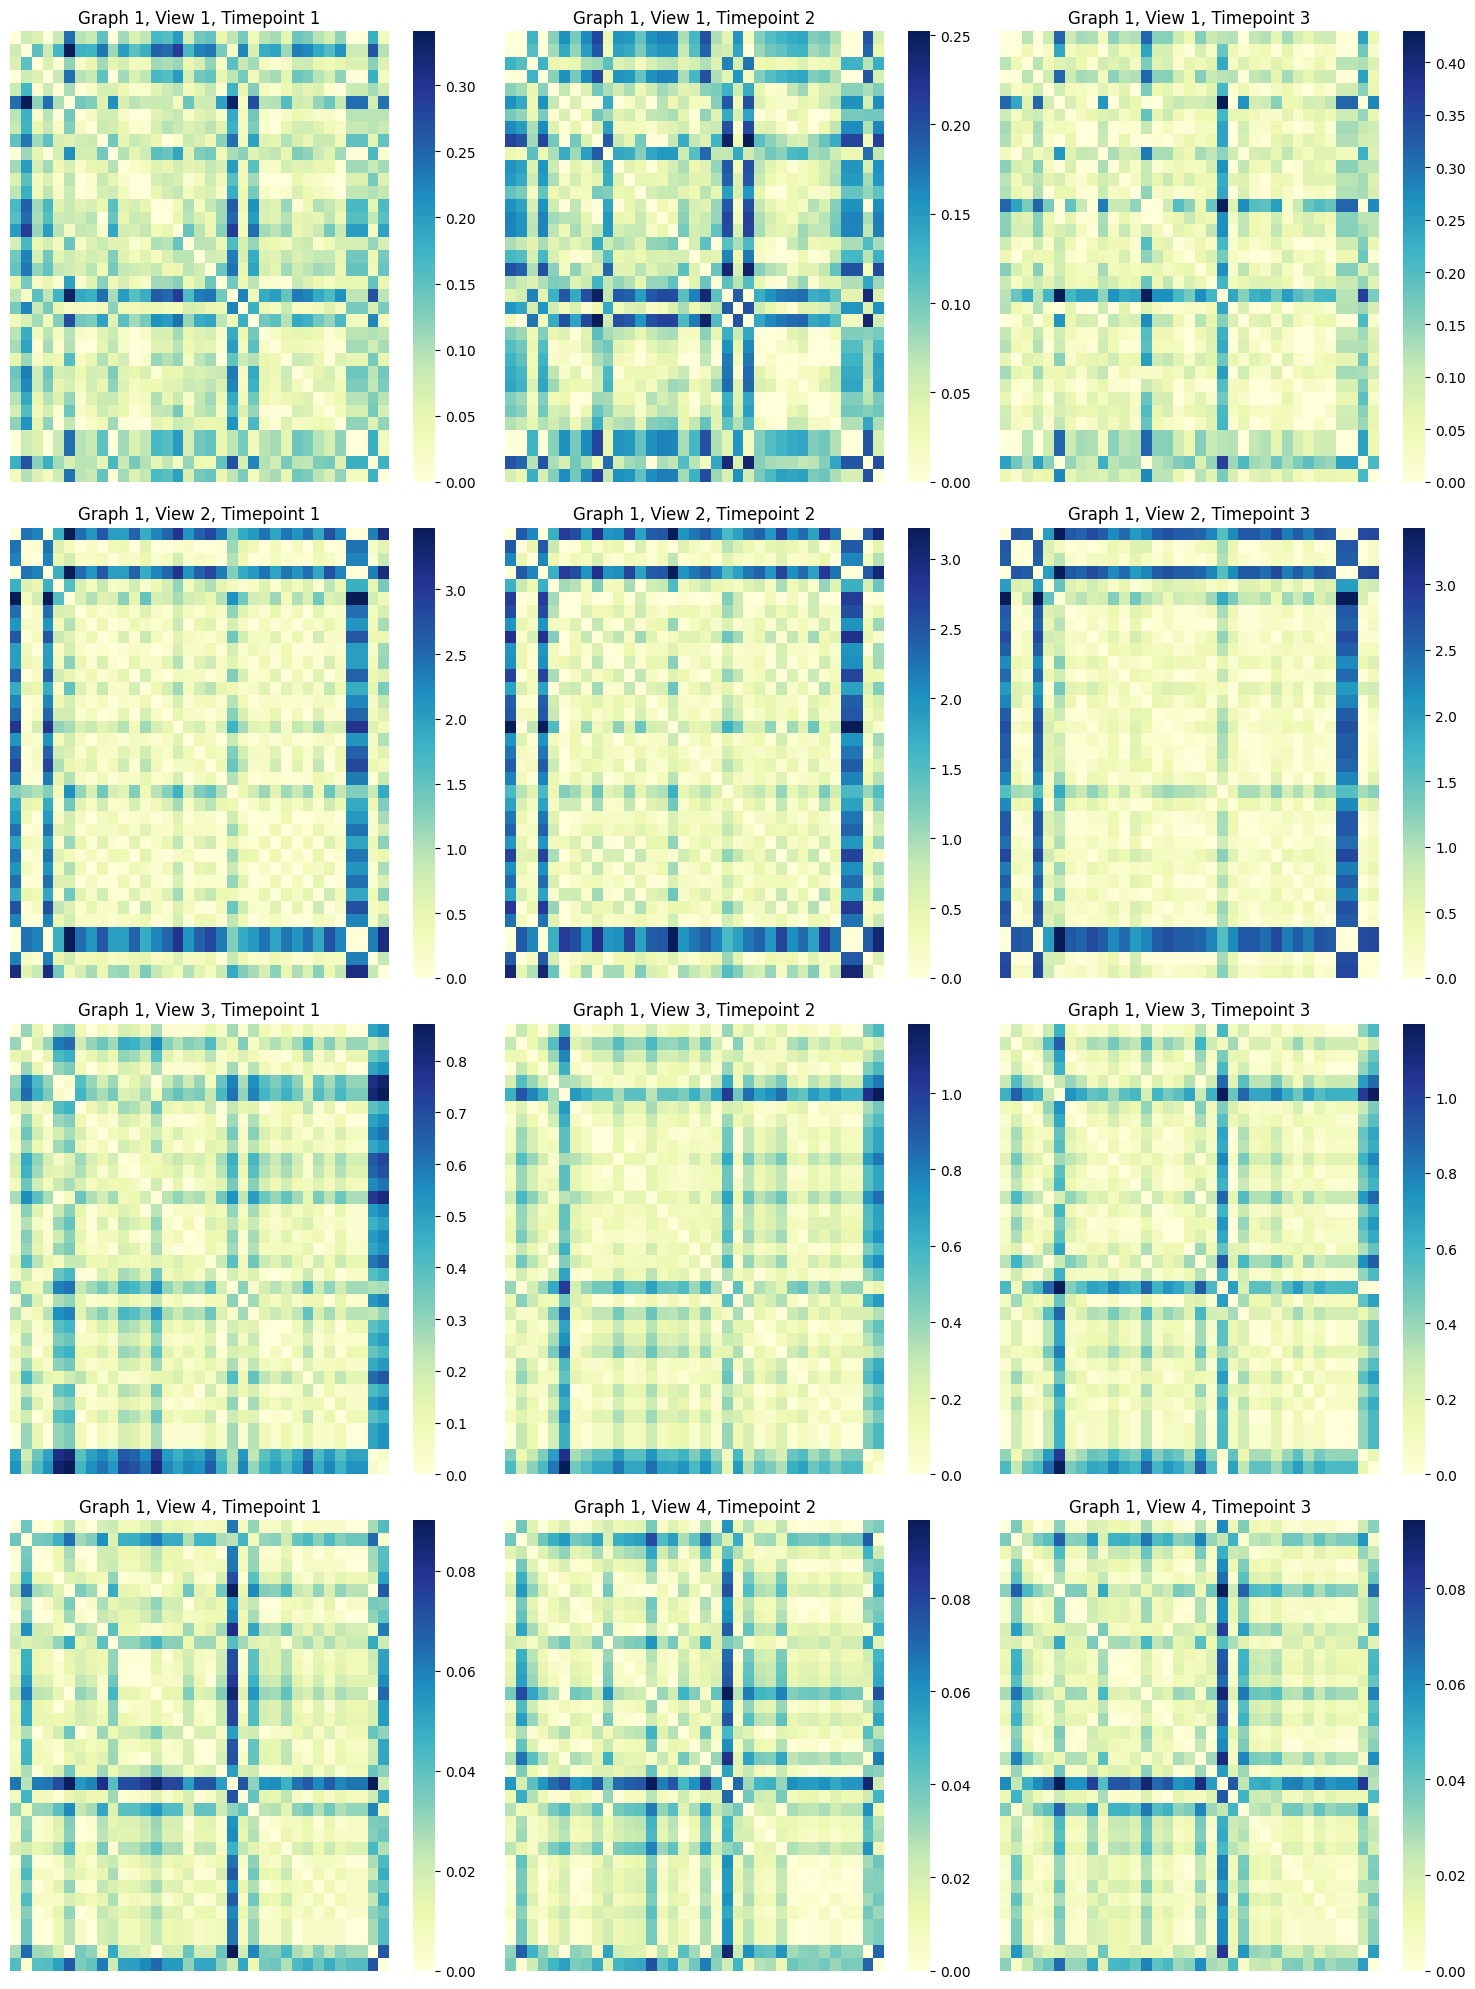

In [17]:
plot_heatmaps(dataset, num_samples=1)

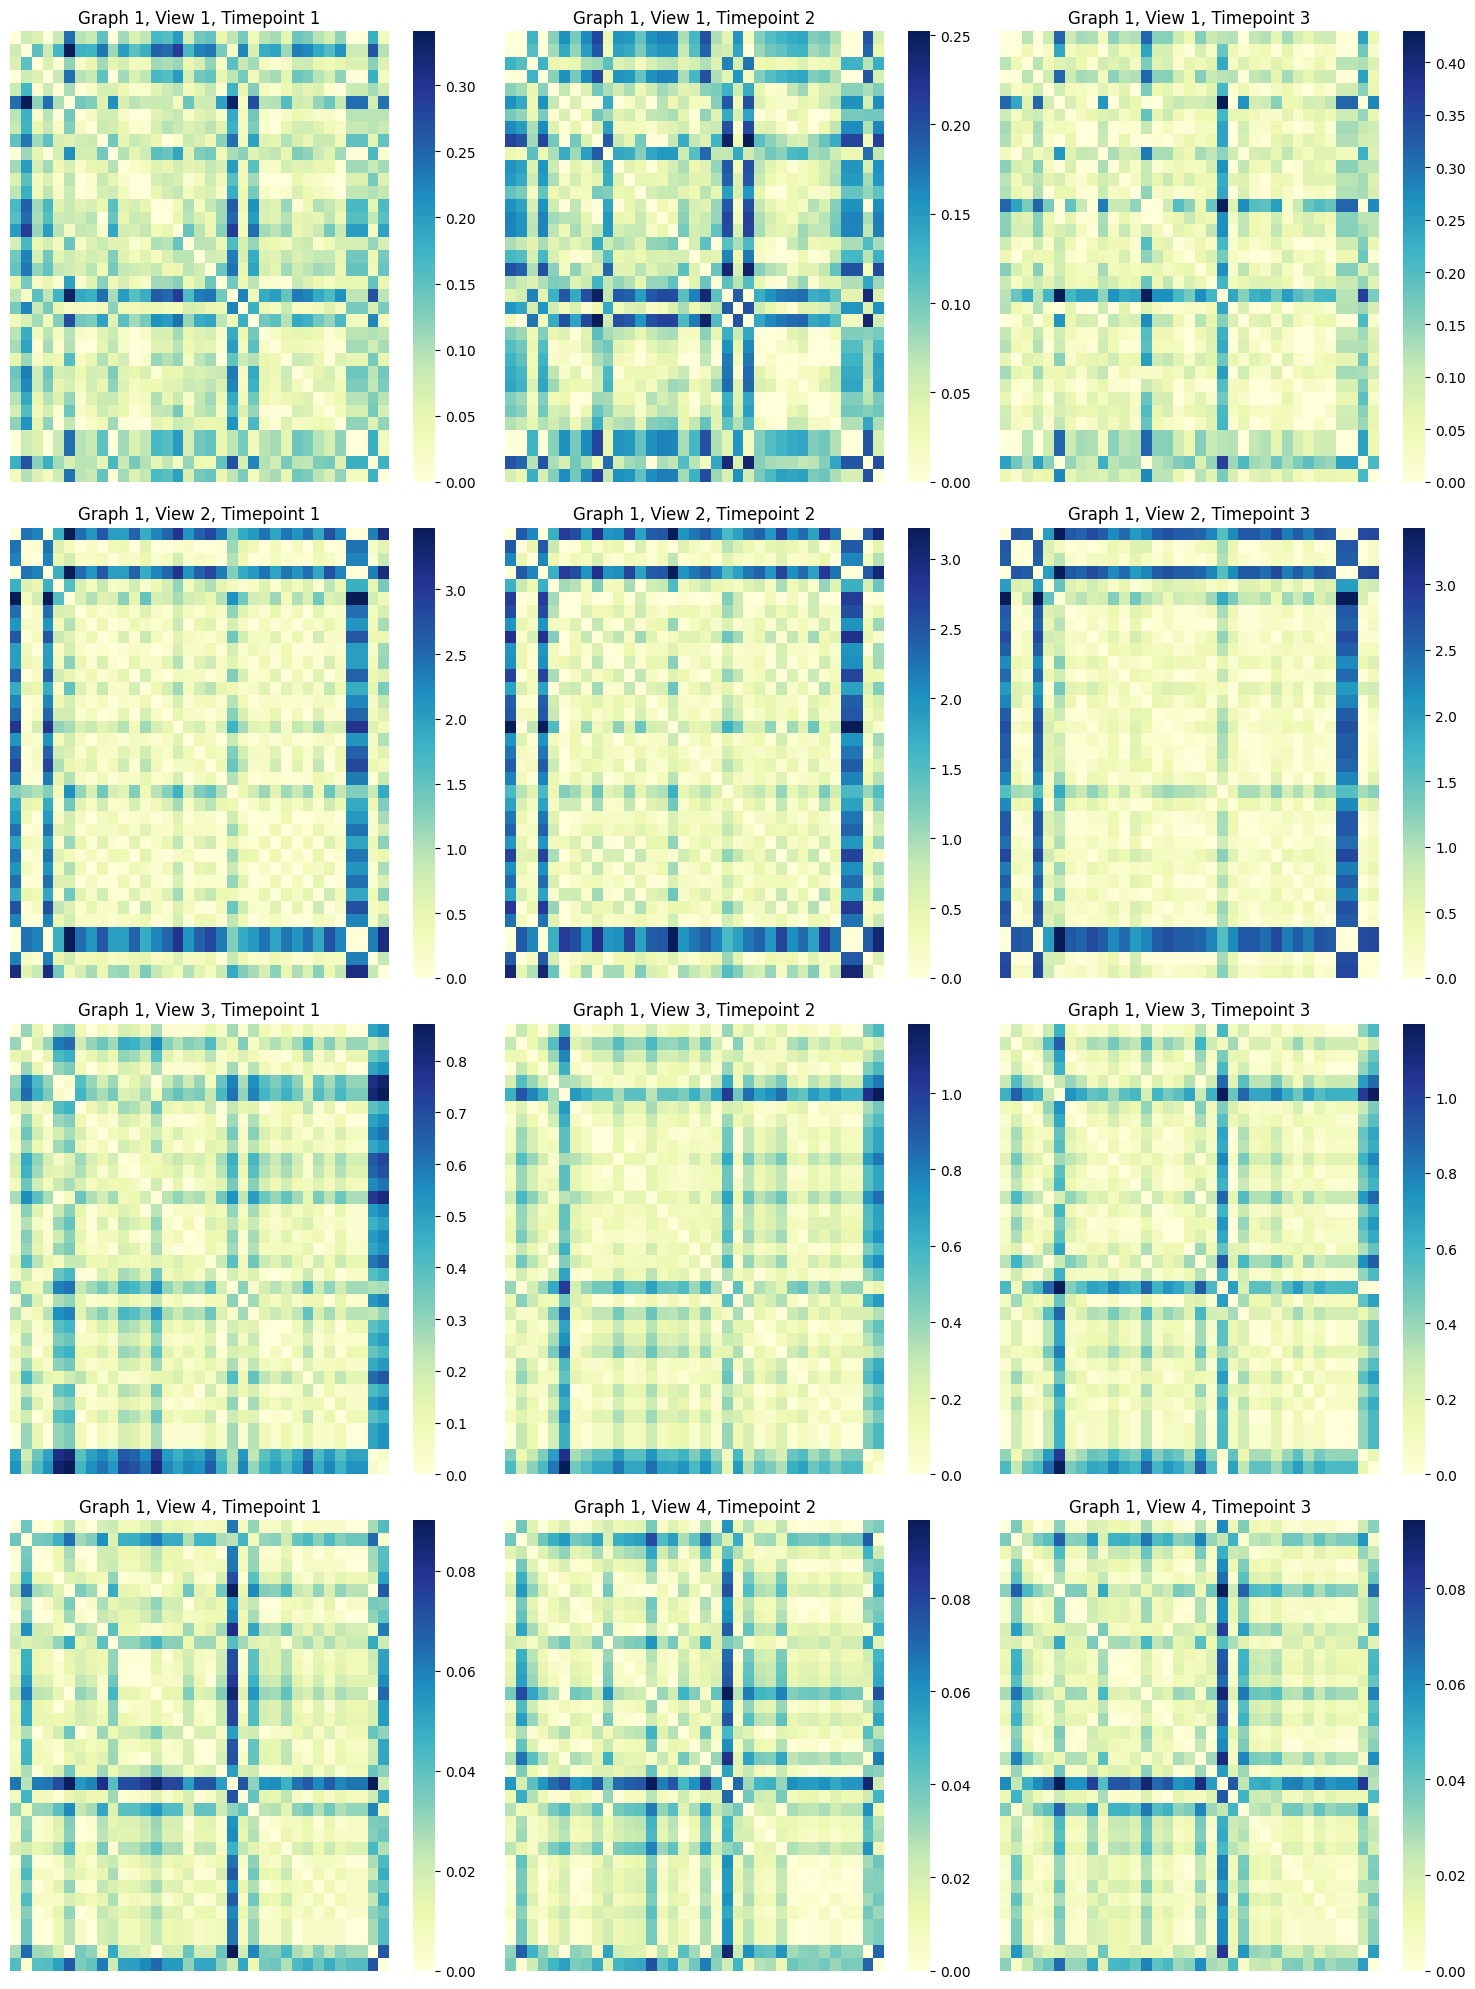

In [18]:
plot_heatmaps(dataset_cleaned, num_samples=1)

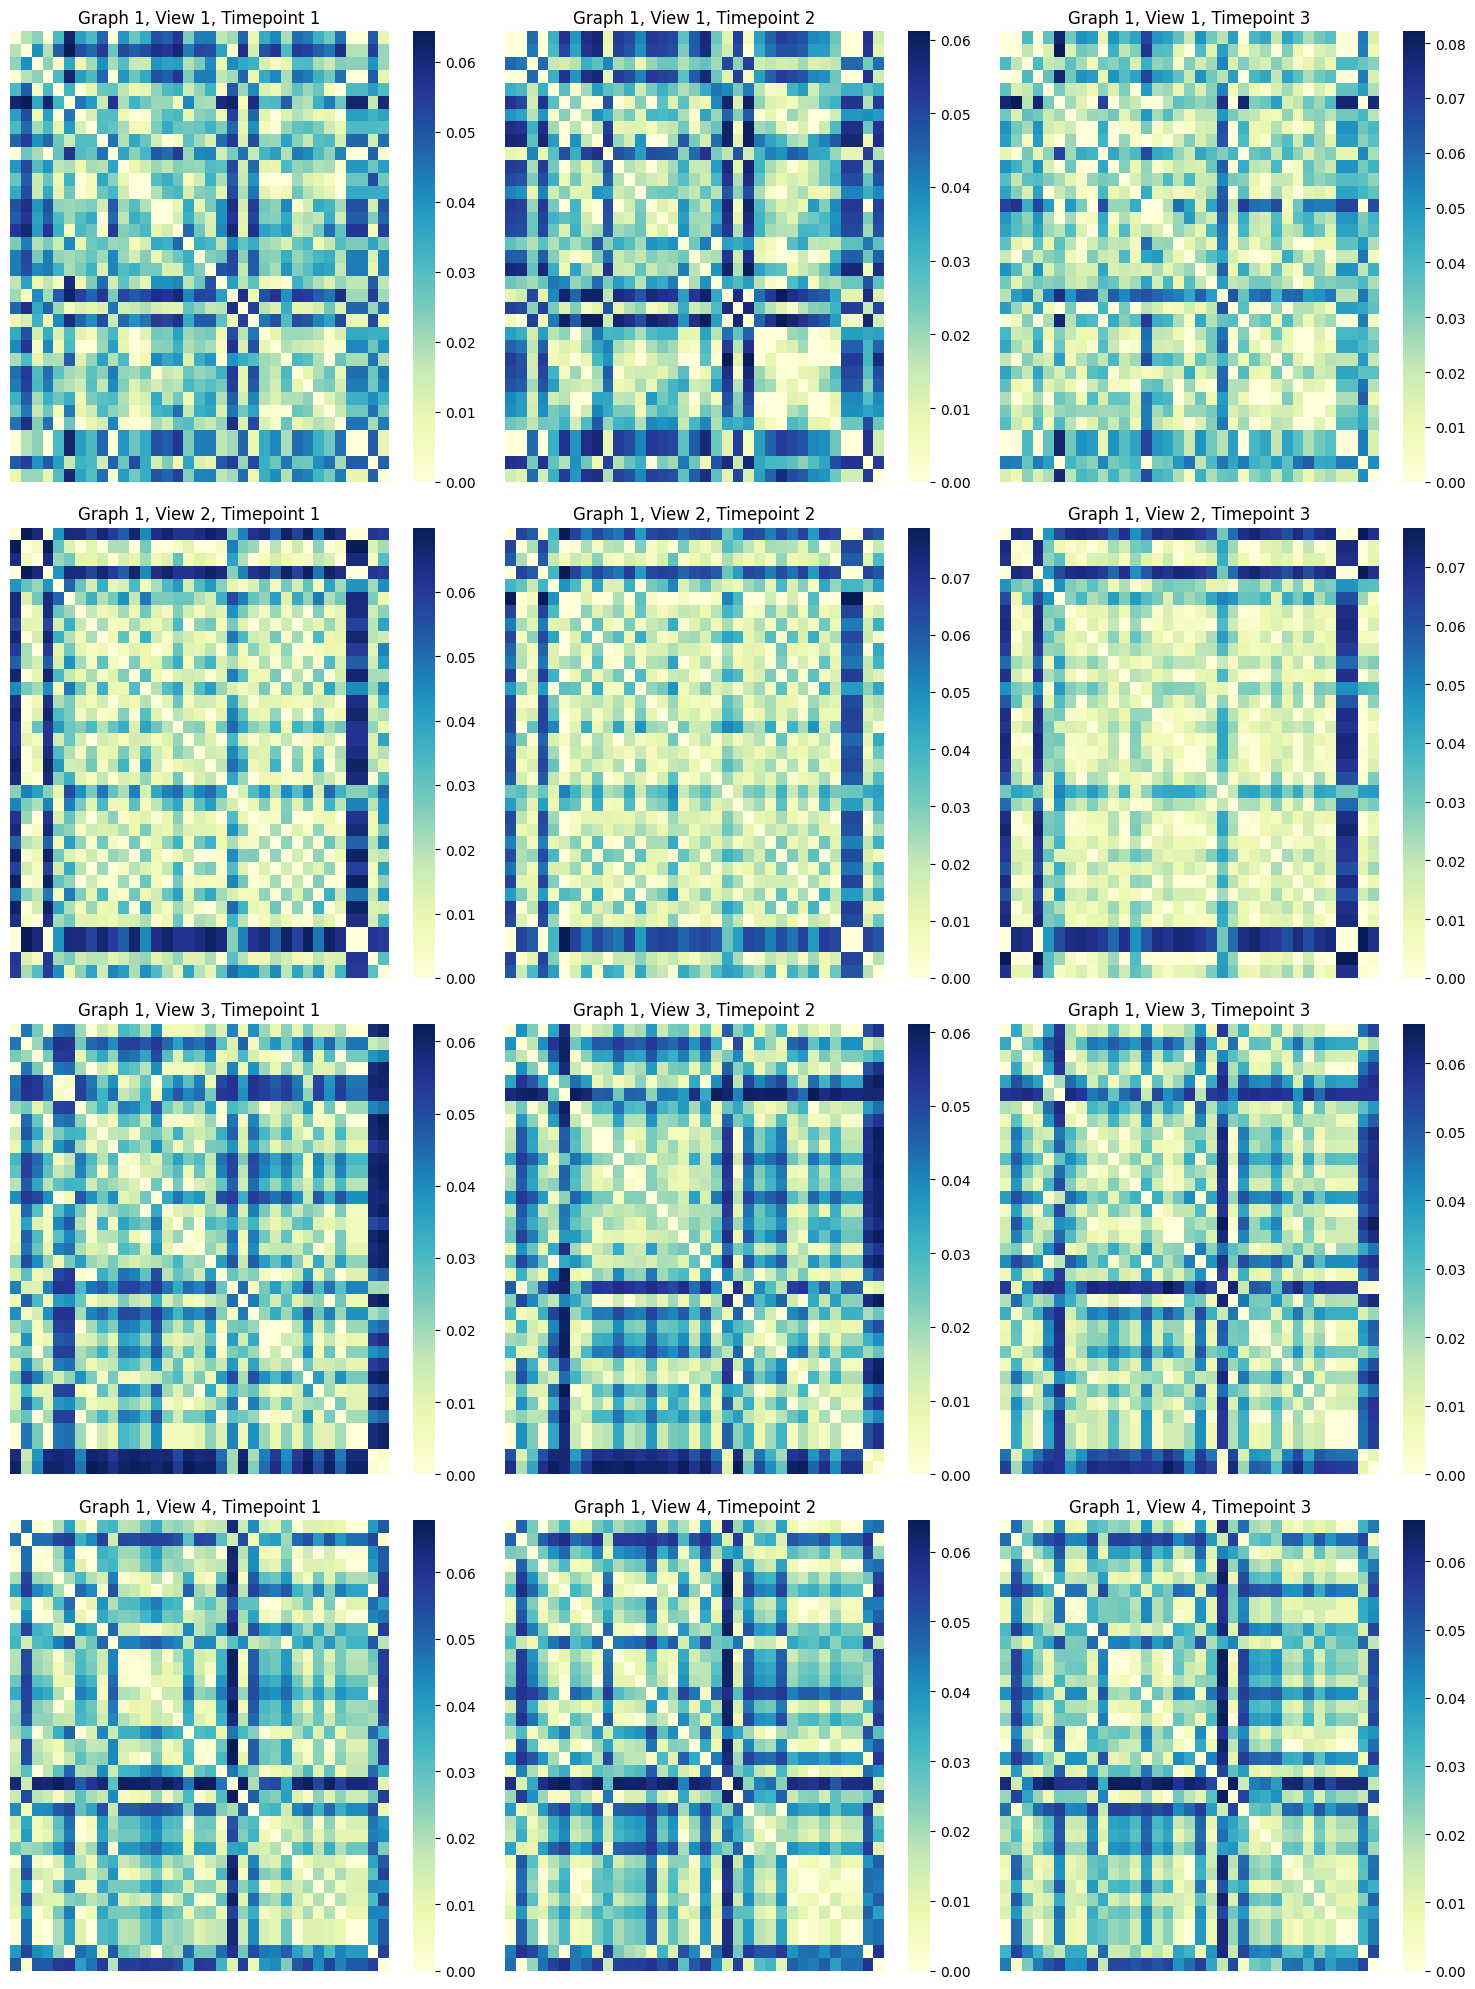

In [19]:
plot_heatmaps(dataset_normalized, num_samples=1)

### Split Train and Test Set

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split

# Function to split the dataset into training and test sets for each domain
def split_dataset_by_domain(adj_matrix, node_features, test_size=0.2, random_state=42):
    num_subjects, num_timepoints, num_nodes, num_features, num_domains = node_features.shape
    
    # Initialize lists to store train and test sets for each domain
    adj_train_sets, adj_test_sets = [], []
    features_train_sets, features_test_sets = [], []
    
    for domain in range(num_domains):
        # Extract data for the current domain
        adj_domain = adj_matrix[..., domain]
        features_domain = node_features[..., domain]
        
        # Generate subject labels
        subject_labels = np.arange(num_subjects)
        
        # Split the dataset for the current domain
        train_idx, test_idx = train_test_split(subject_labels, test_size=test_size, random_state=random_state)
        
        # Create train and test sets for the current domain
        adj_train, adj_test = adj_domain[train_idx], adj_domain[test_idx]
        features_train, features_test = features_domain[train_idx], features_domain[test_idx]
        
        # Append the train and test sets to the lists
        adj_train_sets.append(adj_train)
        adj_test_sets.append(adj_test)
        features_train_sets.append(features_train)
        features_test_sets.append(features_test)
    
    return adj_train_sets, adj_test_sets, features_train_sets, features_test_sets

adj_matrix = dataset_cleaned
# Split the dataset by domain
adj_train_sets, adj_test_sets, features_train_sets, features_test_sets = split_dataset_by_domain(adj_matrix, node_features)

adj_train_domains = []
features_train_domains = []
adj_test_domains = []
features_test_domains = []

for domain in range(num_domains):
    print(f'Domain {domain+1} - Adjacency Train set shape: {adj_train_sets[domain].shape}, Test set shape: {adj_test_sets[domain].shape}')
    print(f'Domain {domain+1} - Node Features Train set shape: {features_train_sets[domain].shape}, Test set shape: {features_test_sets[domain].shape}')
    
    adj_train_domains.append(torch.tensor(adj_train_sets[domain], dtype=torch.float32))
    features_train_domains.append(torch.tensor(features_train_sets[domain], dtype=torch.float32))
    adj_test_domains.append(torch.tensor(adj_test_sets[domain], dtype=torch.float32))
    features_test_domains.append(torch.tensor(features_test_sets[domain], dtype=torch.float32))

Domain 1 - Adjacency Train set shape: (80, 3, 35, 35), Test set shape: (20, 3, 35, 35)
Domain 1 - Node Features Train set shape: (80, 3, 35, 16), Test set shape: (20, 3, 35, 16)
Domain 2 - Adjacency Train set shape: (80, 3, 35, 35), Test set shape: (20, 3, 35, 35)
Domain 2 - Node Features Train set shape: (80, 3, 35, 16), Test set shape: (20, 3, 35, 16)
Domain 3 - Adjacency Train set shape: (80, 3, 35, 35), Test set shape: (20, 3, 35, 35)
Domain 3 - Node Features Train set shape: (80, 3, 35, 16), Test set shape: (20, 3, 35, 16)
Domain 4 - Adjacency Train set shape: (80, 3, 35, 35), Test set shape: (20, 3, 35, 35)
Domain 4 - Node Features Train set shape: (80, 3, 35, 16), Test set shape: (20, 3, 35, 16)


In [12]:
## Training with simulated data
adj_train_domain_1 = adj_train_domains[0]
adj_train_domain_2 = adj_train_domains[1]
adj_train_domain_3 = adj_train_domains[2]
adj_train_domain_4 = adj_train_domains[3] 

features_train_domain_1 = features_train_domains[0]
features_train_domain_2 = features_train_domains[1]
features_train_domain_3 = features_train_domains[2]
features_train_domain_4 = features_train_domains[3]


## Testing with simulated data
adj_test_domain_1 = adj_test_domains[0]
adj_test_domain_2 = adj_test_domains[1]
adj_test_domain_3 = adj_test_domains[2]
adj_test_domain_4 = adj_test_domains[3] 

features_test_domain_1 = features_test_domains[0]
features_test_domain_2 = features_test_domains[1]
features_test_domain_3 = features_test_domains[2]
features_test_domain_4 = features_test_domains[3]

In [13]:
adj_train = adj_train_domain_1
x_train = features_train_domain_1

adj_test = adj_test_domain_1
x_test = features_test_domain_1

# Model

### Definition

In [97]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        # print("gcn weight init:",self.weight.size())
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    # def reset_parameters(self):
    #     nn.init.xavier_uniform_(self.weight)
    #     if self.bias is not None:
    #         nn.init.zeros_(self.bias)

    def forward(self, input, adj):
        # print("gcn weight forward:",self.weight.size())
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


class GCNEncoder(nn.Module):
    def __init__(self, input_dim, feature_dim, latent_dim):
        super(GCNEncoder, self).__init__()
        self.num_nodes = input_dim
        self.feature_dim = feature_dim
        self.hidden_dim = 2 * feature_dim
        self.latent_dim = latent_dim
        
        # GCN layers
        self.conv1 = GCN(feature_dim, self.hidden_dim)
        self.bn1 = nn.BatchNorm1d(self.hidden_dim)
        self.conv2 = GCN(self.hidden_dim, self.latent_dim)
        self.bn2 = nn.BatchNorm1d(self.latent_dim)
        
        self.fc_mu = nn.Linear(self.latent_dim, self.latent_dim)
        self.fc_logvar = nn.Linear(self.latent_dim, self.latent_dim)

    def forward(self, x, adj):
        # GCN layers
        x = F.relu(self.bn1(self.conv1(x, adj)))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.bn2(self.conv2(x, adj)))
        x = F.dropout(x, training=self.training)
        
        # Node features properties
        x_mean = x.mean(dim=0)
        mu = self.fc_mu(x_mean)
        logvar = self.fc_logvar(x_mean)

        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        return z, mu, logvar

class GCNDecoder(nn.Module):
    def __init__(self, latent_dim, num_nodes):
        super(GCNDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.num_nodes = num_nodes
        
        # Fully connected layer to expand z to node features
        self.fc = nn.Linear(latent_dim, num_nodes * latent_dim)
        self.bn0 = nn.BatchNorm1d(latent_dim)

        # GCN layers
        self.conv1 = GCN(latent_dim, latent_dim * 2)
        self.bn1 = nn.BatchNorm1d(latent_dim * 2)
        self.conv2 = GCN(latent_dim * 2, num_nodes * 2)
        self.bn2 = nn.BatchNorm1d(num_nodes * 2)
        self.conv3 = GCN(num_nodes * 2, num_nodes)
        self.bn3 = nn.BatchNorm1d(num_nodes)
    
    def forward(self, z):
        # Expand z to node features
        x = self.bn0(self.fc(z).view(self.num_nodes, self.latent_dim))

        # Initial adjacency matrix (identity matrix)
        adj = torch.eye(self.num_nodes, device=z.device)

        # Pass through GCN layers
        x = F.relu(self.bn1(self.conv1(x, adj)))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.bn2(self.conv2(x, adj)))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.bn3(self.conv3(x, adj)))
        x = F.dropout(x, training=self.training)

        # Generate adjacency matrix
        adj_pred = x

        # Ensure symmetry of the adjacency matrix
        adj_pred = (adj_pred + adj_pred.t()) / 2
        
        return adj_pred


### Definition of Other Decoders

In [15]:

class InnerProductDecoder(nn.Module):
    def __init__(self, act=torch.sigmoid, dropout=0.):
        super(InnerProductDecoder, self).__init__()
        self.act = act
        self.dropout = dropout
    
    def forward(self, inp):
        inp = F.dropout(inp, self.dropout, training=self.training)
        x = torch.transpose(inp, dim0=0, dim1=1)
        x = torch.mm(inp, x)
        return self.act(x)


class FFNDecoder(nn.Module):
    def __init__(self, latent_dim, num_nodes):
        super(FFNDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.num_nodes = num_nodes
        
        # Fully connected layers to generate the adjacency matrix
        self.fc1 = nn.Linear(latent_dim, latent_dim * 2)
        self.fc2 = nn.Linear(latent_dim * 2, num_nodes * num_nodes)

    def forward(self, z):
        # Pass through fully connected layers
        x = F.relu(self.fc1(z))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        # Reshape to the adjacency matrix
        adj_pred = torch.sigmoid(x.view(self.num_nodes, self.num_nodes))

        # Ensure symmetry of the adjacency matrix
        adj_pred = (adj_pred + adj_pred.T) / 2
        
        return adj_pred

#### Model with Inner Product Decoder

In [18]:
class GCRN_ip(nn.Module):
    def __init__(self, input_dim, feature_dim, hidden_dim, num_layers=2):
        super(GCRN_ip, self).__init__()
        self.encoder = GCNEncoder(input_dim, feature_dim)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Create a vanilla GRU layer with the specified number of layers
        self.gru = nn.GRU(feature_dim, hidden_dim, num_layers)
        
        # Use InnerProductDecoder for decoding
        self.decoder = InnerProductDecoder()

    def forward(self, x, adj):
        num_nodes, feature_dim = x.size()
        
        # Encode the current time point
        z, mu, logvar = self.encoder(x, adj)
        z = z.unsqueeze(0).unsqueeze(0)  # (1, 1, feature_dim)
        
        # Initialize hidden states for GRU
        h = torch.zeros(self.num_layers, 1, self.hidden_dim, device=x.device)  # (num_layers, batch_size, hidden_dim)
        
        # Update latent representation using the GRU
        z, h = self.gru(z, h)
        z = z.squeeze(0).squeeze(0) # (hidden_dim,)
        
        # Expand z to create node embeddings
        z_expanded = z.unsqueeze(0).repeat(num_nodes, 1)  # (num_nodes, hidden_dim)
        
        # Decode the expanded latent representation to predict the adjacency matrix
        adj_pred = self.decoder(z_expanded)
        
        return adj_pred, mu, logvar
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

#### Model with FFN Decoders

In [20]:
class GCRN_ffn(nn.Module):
    def __init__(self, input_dim, feature_dim, hidden_dim, num_layers=2):
        super(GCRN_ffn, self).__init__()
        self.encoder = GCNEncoder(input_dim, feature_dim)
        self.decoder = FFNDecoder(hidden_dim, input_dim)  # Assuming input_dim is the number of nodes
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Create a vanilla GRU layer with the specified number of layers
        self.gru = nn.GRU(feature_dim, hidden_dim, num_layers)

    def forward(self, x, adj):
        num_nodes, feature_dim = x.size()
        
        # Encode the current time point
        z, mu, logvar = self.encoder(x, adj)
        z = z.unsqueeze(0).unsqueeze(0)  # (1, 1, feature_dim)
        
        # Initialize hidden states for GRU
        h = torch.zeros(self.num_layers, 1, self.hidden_dim, device=x.device)  # (num_layers, batch_size, hidden_dim)
        
        # Update latent representation using the GRU
        z, h = self.gru(z, h)
        z = z.squeeze(0).squeeze(0) # (hidden_dim,)
        
        # Decode the updated latent representation to predict the adjacency matrix for the next time point
        adj_pred = self.decoder(z)
        
        return adj_pred, mu, logvar
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

### Model with GCN Decoders

In [98]:
class GCRN_gcn(nn.Module):
    def __init__(self, input_dim, feature_dim, latent_dim, num_layers=2):
        super(GCRN_gcn, self).__init__()
        self.hidden_dim = latent_dim
        self.num_layers = num_layers

        self.encoder = GCNEncoder(input_dim, feature_dim, latent_dim)
        # Create a vanilla GRU layer with the specified number of layers
        self.gru = nn.GRU(latent_dim, self.hidden_dim, num_layers)
        self.decoder = GCNDecoder(latent_dim, input_dim)  

    def forward(self, x, adj):
        num_nodes, feature_dim = x.size()
        
        # Encode the current time point
        z, mu, logvar = self.encoder(x, adj)
        z = z.unsqueeze(0).unsqueeze(0) 
        
        # Initialize hidden states for GRU
        h = torch.zeros(self.num_layers, 1, self.hidden_dim, device=x.device)  

        # Update latent representation using the GRU
        z, h = self.gru(z, h)
        z = z.squeeze(0).squeeze(0) 
        
        # Decode the updated latent representation to predict the adjacency matrix for the next time point
        adj_pred = self.decoder(z)
        
        return adj_pred, mu, logvar, z
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


### Loss Function

In [82]:
def loss_function(recon_adj, adj, mu, logvar, lambda_1=1.0, lambda_2=1):
    # Generative loss
    gen_loss = F.l1_loss(recon_adj, adj, reduction='sum')
    
    # Topological loss
    node_strength_recon = torch.sum(recon_adj, dim=1)
    node_strength_gt = torch.sum(adj, dim=1)
    top_loss = F.mse_loss(node_strength_recon, node_strength_gt, reduction='sum')
    
    # KLD loss
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss
    loss = gen_loss + (lambda_1 * top_loss) + (lambda_2 * kld_loss)
    return loss

### Training

#### Vanilla Training

In [99]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import numpy as np
import psutil
import time
import tempfile
from sklearn.manifold import TSNE
from tqdm import tqdm
import os


def train_model(model, train_features, train_adj, num_epochs=100, lr=0.001, save_path='models/gcrn_model.pth'):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    training_loss = []

    epoch_time = []
    cpu_usage = []
    memory_usage = []
    
    images = []

    with tempfile.TemporaryDirectory() as tmp_dir:
        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0
            epoch_start_time = time.time()
            cpu_usage = []
            memory_usage = []

            latent_spaces = []
            time_labels = []

            for i in tqdm(range(train_features.size(0)), desc=f'Epoch {epoch+1}/{num_epochs}'):
                for t in range(train_features.size(1) - 1):
                    optimizer.zero_grad()
                    
                    x_t = train_features[i, t]
                    adj_t = train_adj[i, t]
                    adj_t_next = train_adj[i, t+1]
                    
                    recon_adj, mu, logvar, z = model(x_t, adj_t)
                    loss = loss_function(recon_adj, adj_t_next, mu, logvar)
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item()
                    
                    latent_spaces.append(z.detach().cpu().numpy())
                    time_labels.append(t)

            epoch_end_time = time.time()
            epoch_time.append(epoch_end_time - epoch_start_time)
            cpu_usage.append(psutil.cpu_percent(interval=None))
            memory_usage.append(psutil.virtual_memory().percent)

            epoch_loss /= (train_features.size(0) * (train_features.size(1) - 1))
            training_loss.append(epoch_loss)
            
            # Plotting t-SNE of the latent spaces for the current epoch
            zs = np.vstack(latent_spaces)
            ts = np.array(time_labels)
            z_tsne = TSNE(n_components=2).fit_transform(zs)
            
            plt.figure(figsize=(10, 8))
            
            for t in np.unique(ts):
                idx = ts == t 
                plt.scatter(z_tsne[idx, 0], z_tsne[idx, 1], label=f'Time {t}', alpha=0.5)
        
            plt.title(f't-SNE of VAE Latent Representations (Epoch {epoch+1})')
            plt.xlabel('t-SNE Dimension 1')
            plt.ylabel('t-SNE Dimension 2')
            plt.legend(title='Time point', loc='best')

            # Save the plot as an image file in the temporary directory
            plot_filename = os.path.join(tmp_dir, f'tsne_epoch_{epoch+1}.png')
            plt.savefig(plot_filename)
            images.append(imageio.imread(plot_filename))
            plt.close()
            
            print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')
            print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage[-1]:.2f}%, Memory: {memory_usage[-1]:.2f}%')

        # Plot the training loss
        plt.plot(training_loss)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()

        # Save the trained model
        torch.save(model.state_dict(), save_path)
        print(f'Model saved to {save_path}')

        print(f'Average Time per Epoch: {np.mean(epoch_time):.2f}s')
        print(f'Average CPU Usage: {np.mean(cpu_usage):.2f}%')
        print(f'Average Memory Usage: {np.mean(memory_usage):.2f}%')

        print(f'\nSum Time per Epoch: {np.sum(epoch_time):.2f}s')
        print(f'Sum CPU Usage: {np.sum(cpu_usage):.2f}%')
        print(f'Sum Memory Usage: {np.sum(memory_usage):.2f}%')

        # Create the gif animation
        gif_filename = 'latent_space_analysis/latent_space_animation.gif'
        imageio.mimsave(gif_filename, images, fps=2)
        print(f'Animation saved to {gif_filename}')


In [100]:
# Initialize model
input_dim = 35  
feature_dim = 16
latent_dim = 46
num_rec_layers = 2

#### Model with GCN Decoder

GCRN_gcn(
  (encoder): GCNEncoder(
    (conv1): GCN (16 -> 32)
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (32 -> 46)
    (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_mu): Linear(in_features=46, out_features=46, bias=True)
    (fc_logvar): Linear(in_features=46, out_features=46, bias=True)
  )
  (gru): GRU(46, 46, num_layers=2)
  (decoder): GCNDecoder(
    (fc): Linear(in_features=46, out_features=1610, bias=True)
    (bn0): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): GCN (46 -> 92)
    (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (92 -> 70)
    (bn2): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): GCN (70 -> 35)
    (bn3): BatchNorm1d(35, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Total number o

Epoch 1/100: 100%|██████████| 80/80 [00:00<00:00, 92.92it/s]


Epoch 1, Loss: 5002.246249389648
Time: 0.86s, CPU: 25.80%, Memory: 82.50%


Epoch 2/100: 100%|██████████| 80/80 [00:00<00:00, 82.33it/s]


Epoch 2, Loss: 4530.039082336426
Time: 0.97s, CPU: 59.40%, Memory: 82.40%


Epoch 3/100: 100%|██████████| 80/80 [00:00<00:00, 93.37it/s]


Epoch 3, Loss: 4145.627212524414
Time: 0.86s, CPU: 58.30%, Memory: 82.30%


Epoch 4/100: 100%|██████████| 80/80 [00:00<00:00, 93.58it/s]


Epoch 4, Loss: 3616.2173385620117
Time: 0.86s, CPU: 59.50%, Memory: 82.50%


Epoch 5/100: 100%|██████████| 80/80 [00:00<00:00, 93.41it/s]


Epoch 5, Loss: 2981.323126220703
Time: 0.86s, CPU: 59.90%, Memory: 82.60%


Epoch 6/100: 100%|██████████| 80/80 [00:00<00:00, 84.39it/s]


Epoch 6, Loss: 2365.517323303223
Time: 0.95s, CPU: 62.70%, Memory: 82.40%


Epoch 7/100: 100%|██████████| 80/80 [00:00<00:00, 93.35it/s]


Epoch 7, Loss: 1753.7566997528077
Time: 0.86s, CPU: 59.20%, Memory: 82.50%


Epoch 8/100: 100%|██████████| 80/80 [00:00<00:00, 93.82it/s]


Epoch 8, Loss: 1276.6913692474366
Time: 0.85s, CPU: 58.00%, Memory: 82.50%


Epoch 9/100: 100%|██████████| 80/80 [00:00<00:00, 91.63it/s]


Epoch 9, Loss: 901.2092737197876
Time: 0.88s, CPU: 61.00%, Memory: 82.60%


Epoch 10/100: 100%|██████████| 80/80 [00:00<00:00, 93.88it/s]


Epoch 10, Loss: 643.8431455612183
Time: 0.85s, CPU: 59.90%, Memory: 82.50%


Epoch 11/100: 100%|██████████| 80/80 [00:00<00:00, 84.80it/s]


Epoch 11, Loss: 498.85604257583617
Time: 0.95s, CPU: 61.30%, Memory: 82.40%


Epoch 12/100: 100%|██████████| 80/80 [00:00<00:00, 93.26it/s]


Epoch 12, Loss: 385.17694492340087
Time: 0.86s, CPU: 59.70%, Memory: 82.40%


Epoch 13/100: 100%|██████████| 80/80 [00:00<00:00, 93.62it/s]


Epoch 13, Loss: 323.03097944259645
Time: 0.86s, CPU: 59.90%, Memory: 82.50%


Epoch 14/100: 100%|██████████| 80/80 [00:00<00:00, 93.46it/s]


Epoch 14, Loss: 288.6336727142334
Time: 0.86s, CPU: 59.80%, Memory: 82.40%


Epoch 15/100: 100%|██████████| 80/80 [00:00<00:00, 86.90it/s]


Epoch 15, Loss: 255.97465534210204
Time: 0.92s, CPU: 61.20%, Memory: 82.50%


Epoch 16/100: 100%|██████████| 80/80 [00:00<00:00, 92.06it/s]


Epoch 16, Loss: 227.50332622528077
Time: 0.87s, CPU: 59.70%, Memory: 82.40%


Epoch 17/100: 100%|██████████| 80/80 [00:00<00:00, 93.91it/s]


Epoch 17, Loss: 214.31850204467773
Time: 0.85s, CPU: 59.10%, Memory: 82.50%


Epoch 18/100: 100%|██████████| 80/80 [00:00<00:00, 85.74it/s]


Epoch 18, Loss: 200.06175508499146
Time: 0.93s, CPU: 56.10%, Memory: 81.80%


Epoch 19/100: 100%|██████████| 80/80 [00:00<00:00, 92.76it/s]


Epoch 19, Loss: 190.69545645713805
Time: 0.86s, CPU: 57.60%, Memory: 81.90%


Epoch 20/100: 100%|██████████| 80/80 [00:00<00:00, 93.19it/s]


Epoch 20, Loss: 185.6722382068634
Time: 0.86s, CPU: 59.50%, Memory: 81.90%


Epoch 21/100: 100%|██████████| 80/80 [00:00<00:00, 92.00it/s]


Epoch 21, Loss: 183.35949873924255
Time: 0.87s, CPU: 59.10%, Memory: 82.00%


Epoch 22/100: 100%|██████████| 80/80 [00:00<00:00, 94.17it/s] 


Epoch 22, Loss: 176.93275184631347
Time: 0.85s, CPU: 72.80%, Memory: 83.00%


Epoch 23/100: 100%|██████████| 80/80 [00:00<00:00, 132.46it/s]


Epoch 23, Loss: 169.01602540016174
Time: 0.61s, CPU: 73.50%, Memory: 82.90%


Epoch 24/100: 100%|██████████| 80/80 [00:00<00:00, 133.20it/s]


Epoch 24, Loss: 163.69179859161378
Time: 0.60s, CPU: 70.90%, Memory: 82.90%


Epoch 25/100: 100%|██████████| 80/80 [00:00<00:00, 132.49it/s]


Epoch 25, Loss: 161.18066058158874
Time: 0.61s, CPU: 70.40%, Memory: 83.00%


Epoch 26/100: 100%|██████████| 80/80 [00:00<00:00, 120.32it/s]


Epoch 26, Loss: 153.73084301948546
Time: 0.67s, CPU: 71.80%, Memory: 82.60%


Epoch 27/100: 100%|██████████| 80/80 [00:00<00:00, 132.15it/s]


Epoch 27, Loss: 158.47734270095825
Time: 0.61s, CPU: 71.90%, Memory: 82.60%


Epoch 28/100: 100%|██████████| 80/80 [00:00<00:00, 132.89it/s]


Epoch 28, Loss: 150.25718407630922
Time: 0.60s, CPU: 70.30%, Memory: 82.70%


Epoch 29/100: 100%|██████████| 80/80 [00:00<00:00, 132.21it/s]


Epoch 29, Loss: 147.02762656211854
Time: 0.61s, CPU: 70.30%, Memory: 82.80%


Epoch 30/100: 100%|██████████| 80/80 [00:00<00:00, 131.10it/s]


Epoch 30, Loss: 142.43633942604066
Time: 0.61s, CPU: 78.80%, Memory: 82.80%


Epoch 31/100: 100%|██████████| 80/80 [00:00<00:00, 119.12it/s]


Epoch 31, Loss: 141.5307153224945
Time: 0.67s, CPU: 74.70%, Memory: 82.90%


Epoch 32/100: 100%|██████████| 80/80 [00:00<00:00, 132.58it/s]


Epoch 32, Loss: 136.32103099823
Time: 0.60s, CPU: 73.40%, Memory: 82.90%


Epoch 33/100: 100%|██████████| 80/80 [00:00<00:00, 133.59it/s]


Epoch 33, Loss: 135.00252356529236
Time: 0.60s, CPU: 67.90%, Memory: 82.90%


Epoch 34/100: 100%|██████████| 80/80 [00:00<00:00, 131.30it/s]


Epoch 34, Loss: 131.76416726112365
Time: 0.61s, CPU: 70.40%, Memory: 83.00%


Epoch 35/100: 100%|██████████| 80/80 [00:00<00:00, 133.44it/s]


Epoch 35, Loss: 127.20636510848999
Time: 0.60s, CPU: 68.70%, Memory: 83.00%


Epoch 36/100: 100%|██████████| 80/80 [00:00<00:00, 120.90it/s]


Epoch 36, Loss: 123.74891319274903
Time: 0.66s, CPU: 71.70%, Memory: 83.00%


Epoch 37/100: 100%|██████████| 80/80 [00:00<00:00, 132.57it/s]


Epoch 37, Loss: 122.00065083503723
Time: 0.61s, CPU: 68.00%, Memory: 83.00%


Epoch 38/100: 100%|██████████| 80/80 [00:00<00:00, 133.62it/s]


Epoch 38, Loss: 122.14528856277465
Time: 0.60s, CPU: 71.40%, Memory: 83.20%


Epoch 39/100: 100%|██████████| 80/80 [00:00<00:00, 131.96it/s]


Epoch 39, Loss: 118.21145300865173
Time: 0.61s, CPU: 69.60%, Memory: 83.20%


Epoch 40/100: 100%|██████████| 80/80 [00:00<00:00, 122.62it/s]


Epoch 40, Loss: 119.96414918899536
Time: 0.65s, CPU: 71.00%, Memory: 83.20%


Epoch 41/100: 100%|██████████| 80/80 [00:00<00:00, 133.75it/s]


Epoch 41, Loss: 116.82754230499268
Time: 0.60s, CPU: 67.50%, Memory: 83.10%


Epoch 42/100: 100%|██████████| 80/80 [00:00<00:00, 131.07it/s]


Epoch 42, Loss: 116.27767758369446
Time: 0.61s, CPU: 69.70%, Memory: 82.90%


Epoch 43/100: 100%|██████████| 80/80 [00:00<00:00, 132.70it/s]


Epoch 43, Loss: 115.68529186248779
Time: 0.60s, CPU: 68.20%, Memory: 83.10%


Epoch 44/100: 100%|██████████| 80/80 [00:00<00:00, 132.93it/s]


Epoch 44, Loss: 113.50438985824584
Time: 0.60s, CPU: 70.00%, Memory: 83.00%


Epoch 45/100: 100%|██████████| 80/80 [00:00<00:00, 129.57it/s]


Epoch 45, Loss: 113.70009388923646
Time: 0.62s, CPU: 72.30%, Memory: 83.00%


Epoch 46/100: 100%|██████████| 80/80 [00:00<00:00, 133.53it/s]


Epoch 46, Loss: 112.71931300163268
Time: 0.60s, CPU: 72.10%, Memory: 83.50%


Epoch 47/100: 100%|██████████| 80/80 [00:00<00:00, 134.28it/s]


Epoch 47, Loss: 112.26889977455139
Time: 0.60s, CPU: 72.20%, Memory: 84.20%


Epoch 48/100: 100%|██████████| 80/80 [00:00<00:00, 132.21it/s]


Epoch 48, Loss: 112.13775491714478
Time: 0.61s, CPU: 69.20%, Memory: 83.40%


Epoch 49/100: 100%|██████████| 80/80 [00:00<00:00, 134.19it/s]


Epoch 49, Loss: 110.51636543273926
Time: 0.60s, CPU: 80.40%, Memory: 83.30%


Epoch 50/100: 100%|██████████| 80/80 [00:00<00:00, 120.05it/s]


Epoch 50, Loss: 111.50069484710693
Time: 0.67s, CPU: 72.50%, Memory: 83.20%


Epoch 51/100: 100%|██████████| 80/80 [00:00<00:00, 132.65it/s]


Epoch 51, Loss: 110.09112634658814
Time: 0.60s, CPU: 68.00%, Memory: 83.20%


Epoch 52/100: 100%|██████████| 80/80 [00:00<00:00, 132.25it/s]


Epoch 52, Loss: 110.13743419647217
Time: 0.61s, CPU: 70.50%, Memory: 83.30%


Epoch 53/100: 100%|██████████| 80/80 [00:00<00:00, 132.37it/s]


Epoch 53, Loss: 109.74835567474365
Time: 0.61s, CPU: 66.40%, Memory: 83.10%


Epoch 54/100: 100%|██████████| 80/80 [00:00<00:00, 134.14it/s]


Epoch 54, Loss: 109.48538241386413
Time: 0.60s, CPU: 68.50%, Memory: 83.10%


Epoch 55/100: 100%|██████████| 80/80 [00:00<00:00, 120.90it/s]


Epoch 55, Loss: 109.33884787559509
Time: 0.66s, CPU: 70.60%, Memory: 83.10%


Epoch 56/100: 100%|██████████| 80/80 [00:00<00:00, 132.93it/s]


Epoch 56, Loss: 107.56314854621887
Time: 0.60s, CPU: 68.40%, Memory: 83.10%


Epoch 57/100: 100%|██████████| 80/80 [00:00<00:00, 130.95it/s]


Epoch 57, Loss: 110.10086793899536
Time: 0.61s, CPU: 68.90%, Memory: 83.10%


Epoch 58/100: 100%|██████████| 80/80 [00:00<00:00, 132.89it/s]


Epoch 58, Loss: 107.67083730697632
Time: 0.60s, CPU: 71.10%, Memory: 83.10%


Epoch 59/100: 100%|██████████| 80/80 [00:00<00:00, 132.77it/s]


Epoch 59, Loss: 106.89011101722717
Time: 0.60s, CPU: 70.60%, Memory: 83.10%


Epoch 60/100: 100%|██████████| 80/80 [00:00<00:00, 133.52it/s]


Epoch 60, Loss: 106.84538640975953
Time: 0.60s, CPU: 67.40%, Memory: 83.70%


Epoch 61/100: 100%|██████████| 80/80 [00:00<00:00, 132.91it/s]


Epoch 61, Loss: 106.02327919006348
Time: 0.60s, CPU: 70.90%, Memory: 83.80%


Epoch 62/100: 100%|██████████| 80/80 [00:00<00:00, 131.78it/s]


Epoch 62, Loss: 104.74287118911744
Time: 0.61s, CPU: 69.40%, Memory: 83.10%


Epoch 63/100: 100%|██████████| 80/80 [00:00<00:00, 132.18it/s]


Epoch 63, Loss: 105.9017599105835
Time: 0.61s, CPU: 67.00%, Memory: 83.30%


Epoch 64/100: 100%|██████████| 80/80 [00:00<00:00, 132.75it/s]


Epoch 64, Loss: 103.87500848770142
Time: 0.60s, CPU: 67.90%, Memory: 83.20%


Epoch 65/100: 100%|██████████| 80/80 [00:00<00:00, 137.51it/s]


Epoch 65, Loss: 105.98392853736877
Time: 0.58s, CPU: 90.90%, Memory: 83.60%


Epoch 66/100: 100%|██████████| 80/80 [00:00<00:00, 108.89it/s]


Epoch 66, Loss: 104.98087520599366
Time: 0.74s, CPU: 87.30%, Memory: 84.00%


Epoch 67/100: 100%|██████████| 80/80 [00:00<00:00, 129.17it/s]


Epoch 67, Loss: 103.98403329849243
Time: 0.62s, CPU: 89.30%, Memory: 84.10%


Epoch 68/100: 100%|██████████| 80/80 [00:00<00:00, 137.02it/s]


Epoch 68, Loss: 103.72585320472717
Time: 0.59s, CPU: 87.60%, Memory: 84.30%


Epoch 69/100: 100%|██████████| 80/80 [00:00<00:00, 131.60it/s]


Epoch 69, Loss: 103.56133728027343
Time: 0.61s, CPU: 88.30%, Memory: 84.30%


Epoch 70/100: 100%|██████████| 80/80 [00:00<00:00, 139.63it/s]


Epoch 70, Loss: 103.0058831691742
Time: 0.57s, CPU: 76.50%, Memory: 83.50%


Epoch 71/100: 100%|██████████| 80/80 [00:00<00:00, 113.35it/s]


Epoch 71, Loss: 102.81613864898682
Time: 0.71s, CPU: 85.00%, Memory: 83.50%


Epoch 72/100: 100%|██████████| 80/80 [00:00<00:00, 128.82it/s]


Epoch 72, Loss: 103.5748505115509
Time: 0.62s, CPU: 82.10%, Memory: 83.70%


Epoch 73/100: 100%|██████████| 80/80 [00:00<00:00, 133.57it/s]


Epoch 73, Loss: 102.06327471733093
Time: 0.60s, CPU: 73.60%, Memory: 83.80%


Epoch 74/100: 100%|██████████| 80/80 [00:00<00:00, 131.61it/s]


Epoch 74, Loss: 102.14666152000427
Time: 0.61s, CPU: 70.60%, Memory: 83.90%


Epoch 75/100: 100%|██████████| 80/80 [00:00<00:00, 133.80it/s]


Epoch 75, Loss: 102.01770286560058
Time: 0.60s, CPU: 77.40%, Memory: 84.10%


Epoch 76/100: 100%|██████████| 80/80 [00:00<00:00, 131.63it/s]


Epoch 76, Loss: 103.23491830825806
Time: 0.61s, CPU: 73.20%, Memory: 83.80%


Epoch 77/100: 100%|██████████| 80/80 [00:00<00:00, 130.79it/s]


Epoch 77, Loss: 102.39301824569702
Time: 0.61s, CPU: 66.50%, Memory: 83.80%


Epoch 78/100: 100%|██████████| 80/80 [00:00<00:00, 130.57it/s]


Epoch 78, Loss: 102.87096600532531
Time: 0.61s, CPU: 68.20%, Memory: 83.80%


Epoch 79/100: 100%|██████████| 80/80 [00:00<00:00, 131.47it/s]


Epoch 79, Loss: 101.72431101799012
Time: 0.61s, CPU: 68.40%, Memory: 83.80%


Epoch 80/100: 100%|██████████| 80/80 [00:00<00:00, 133.44it/s]


Epoch 80, Loss: 102.6816569328308
Time: 0.60s, CPU: 67.20%, Memory: 83.90%


Epoch 81/100: 100%|██████████| 80/80 [00:00<00:00, 132.03it/s]


Epoch 81, Loss: 102.39197616577148
Time: 0.61s, CPU: 69.40%, Memory: 83.90%


Epoch 82/100: 100%|██████████| 80/80 [00:00<00:00, 131.18it/s]


Epoch 82, Loss: 102.14462766647338
Time: 0.61s, CPU: 66.50%, Memory: 83.90%


Epoch 83/100: 100%|██████████| 80/80 [00:00<00:00, 131.92it/s]


Epoch 83, Loss: 102.03457593917847
Time: 0.61s, CPU: 68.20%, Memory: 83.80%


Epoch 84/100: 100%|██████████| 80/80 [00:00<00:00, 130.29it/s]


Epoch 84, Loss: 102.36676411628723
Time: 0.62s, CPU: 69.50%, Memory: 83.80%


Epoch 85/100: 100%|██████████| 80/80 [00:00<00:00, 131.63it/s]


Epoch 85, Loss: 101.65133094787598
Time: 0.61s, CPU: 68.20%, Memory: 83.70%


Epoch 86/100: 100%|██████████| 80/80 [00:00<00:00, 132.37it/s]


Epoch 86, Loss: 102.67262287139893
Time: 0.61s, CPU: 68.40%, Memory: 83.90%


Epoch 87/100: 100%|██████████| 80/80 [00:00<00:00, 131.58it/s]


Epoch 87, Loss: 103.06054925918579
Time: 0.61s, CPU: 66.30%, Memory: 83.80%


Epoch 88/100: 100%|██████████| 80/80 [00:00<00:00, 131.75it/s]


Epoch 88, Loss: 100.85657014846802
Time: 0.61s, CPU: 68.40%, Memory: 83.80%


Epoch 89/100: 100%|██████████| 80/80 [00:00<00:00, 132.51it/s]


Epoch 89, Loss: 101.9828330039978
Time: 0.61s, CPU: 66.90%, Memory: 83.90%


Epoch 90/100: 100%|██████████| 80/80 [00:00<00:00, 132.67it/s]


Epoch 90, Loss: 101.265868806839
Time: 0.60s, CPU: 67.80%, Memory: 83.80%


Epoch 91/100: 100%|██████████| 80/80 [00:00<00:00, 131.03it/s]


Epoch 91, Loss: 101.14435048103333
Time: 0.61s, CPU: 68.30%, Memory: 83.90%


Epoch 92/100: 100%|██████████| 80/80 [00:00<00:00, 132.65it/s]


Epoch 92, Loss: 101.18312511444091
Time: 0.60s, CPU: 69.00%, Memory: 83.90%


Epoch 93/100: 100%|██████████| 80/80 [00:00<00:00, 133.58it/s]


Epoch 93, Loss: 100.94042634963989
Time: 0.60s, CPU: 67.70%, Memory: 84.00%


Epoch 94/100: 100%|██████████| 80/80 [00:00<00:00, 132.75it/s]


Epoch 94, Loss: 101.51044898033142
Time: 0.60s, CPU: 68.00%, Memory: 84.00%


Epoch 95/100: 100%|██████████| 80/80 [00:00<00:00, 121.50it/s]


Epoch 95, Loss: 101.3352502822876
Time: 0.66s, CPU: 69.60%, Memory: 83.90%


Epoch 96/100: 100%|██████████| 80/80 [00:00<00:00, 134.03it/s]


Epoch 96, Loss: 99.98240885734558
Time: 0.60s, CPU: 69.40%, Memory: 83.90%


Epoch 97/100: 100%|██████████| 80/80 [00:00<00:00, 132.88it/s]


Epoch 97, Loss: 99.91499376296997
Time: 0.60s, CPU: 69.50%, Memory: 83.90%


Epoch 98/100: 100%|██████████| 80/80 [00:00<00:00, 131.39it/s]


Epoch 98, Loss: 100.38466353416443
Time: 0.61s, CPU: 69.00%, Memory: 84.00%


Epoch 99/100: 100%|██████████| 80/80 [00:00<00:00, 129.81it/s]


Epoch 99, Loss: 100.50691165924073
Time: 0.62s, CPU: 70.60%, Memory: 84.50%


Epoch 100/100: 100%|██████████| 80/80 [00:00<00:00, 115.95it/s]


Epoch 100, Loss: 100.75413403511047
Time: 0.69s, CPU: 71.70%, Memory: 84.30%


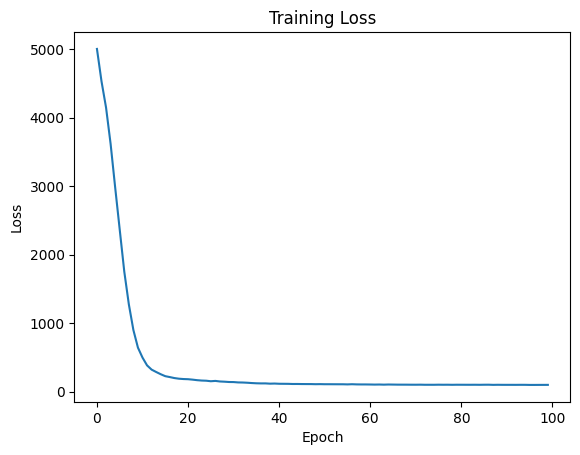

Model saved to models/gcrn_gcn_dom1.pth
Average Time per Epoch: 0.67s
Average CPU Usage: 71.70%
Average Memory Usage: 84.30%

Sum Time per Epoch: 67.29s
Sum CPU Usage: 71.70%
Sum Memory Usage: 84.30%
Animation saved to latent_space_analysis/latent_space_animation.gif


In [102]:

model_gcn = GCRN_gcn(input_dim, feature_dim, latent_dim, num_rec_layers)
print(model_gcn)
print(f"Total number of trainable parameters: {model_gcn.count_parameters()}\n")

# Train model 
train_model(model_gcn, x_train, adj_train, num_epochs=100, lr=0.0001, save_path="models/gcrn_gcn_dom1.pth")

# # Train model with gradient analyis
# train_model_with_gradient_analysis(model_gcn, x_train, adj_train,model_path="models/gcrn_gcn_dom1.pth", gif_path="gradient_analysis/",  num_epochs=60, lr=0.0001)

#### Gradient Analysis

In [17]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
import tempfile
import os
import gc
from concurrent.futures import ThreadPoolExecutor

def plot_grad_flow(named_parameters, step, tmp_dir):
    ave_grads = []
    max_grads = []
    layers = []
    for n, p in named_parameters:
        if p.requires_grad and "bias" not in n:
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())  # Move to CPU
            max_grads.append(p.grad.abs().max().cpu())   # Move to CPU
    
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.plot(max_grads, alpha=0.3, color="r")
    plt.hlines(0, 0, len(ave_grads) + 1, linewidth=1, color="k")
    plt.xticks(range(0, len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title(f"Gradient flow, step {step}")
    plt.grid(True)
    plt.tight_layout()
    
    # Save the plot as an image file in the temporary directory
    filename = os.path.join(tmp_dir, f"grad_flow_{step}.png")
    plt.savefig(filename)
    plt.close()


def create_gif_grad(image_folder, gif_name):
    images = []
    for file_name in sorted(os.listdir(image_folder)):
        if file_name.startswith('grad_flow_') and file_name.endswith('.png'):
            file_path = os.path.join(image_folder, file_name)
            images.append(Image.open(file_path))
    images[0].save(gif_name, save_all=True, append_images=images[1:], duration=500, loop=0)


def plot_grad_flow_async(named_parameters, step, tmp_dir):
    with ThreadPoolExecutor() as executor:
        future = executor.submit(plot_grad_flow, named_parameters, step, tmp_dir)
        return future


def train_model_with_gradient_analysis(model, train_features, train_adj, model_path, gif_path, num_epochs=100, lr=0.001, plot_interval=10):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    training_loss = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    with tempfile.TemporaryDirectory() as tmp_dir:
        step = 0
        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0
            batch_counter = 0

            for i in range(train_features.size(0)):
                for t in range(train_features.size(1) - 1):  # Loop over time points
                    optimizer.zero_grad()
                    
                    # Extract current and next time point data
                    x_t = train_features[i, t].to(device)  # Current time point node features
                    adj_t = train_adj[i, t].to(device)     # Current time point adjacency matrix
                    adj_t_next = train_adj[i, t+1].to(device)  # Next time point adjacency matrix (ground truth)
                    
                    # Forward pass
                    recon_adj, mu, logvar = model(x_t, adj_t)
                    # Compute loss
                    loss = loss_function(recon_adj, adj_t_next, mu, logvar)
                    
                    # Backward pass and optimization
                    loss.backward()
                    
                    # Plot gradient flow asynchronously every plot_interval steps
                    if step % plot_interval == 0:
                        plot_grad_flow_async(model.named_parameters(), step, tmp_dir)

                    optimizer.step()
                    
                    epoch_loss += loss.item()
                    batch_counter += 1
                    step += 1

                    torch.cuda.empty_cache()
                    gc.collect()

            epoch_loss /= (train_features.size(0) * (train_features.size(1) - 1))
            training_loss.append(epoch_loss)
            
            print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')

        # Plot the training loss
        plt.plot(training_loss)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()

        # Save the trained model
        torch.save(model.state_dict(), model_path)
        print(f'Model saved to {model_path}')

        # Create gif of gradient flow
        gif_path = f"{os.path.dirname(gif_path)}/gradient_flow.gif"
        create_gif_grad(tmp_dir, gif_path)
        print(f"Gradient flow saved as {gif_path}")


In [ ]:

# Train model with gradient analyis
train_model_with_gradient_analysis(model_gcn, x_train, adj_train,model_path="models/gcrn_gcn_dom1.pth", gif_path="gradient_analysis/",  num_epochs=60, lr=0.0001)

### Training with Other Decoders

#### Model with Inner Product Decoder

GCRN_ip(
  (encoder): GCNEncoder(
    (conv1): GCN (16 -> 32)
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (32 -> 16)
    (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_mu): Linear(in_features=16, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=16, out_features=16, bias=True)
  )
  (gru): GRU(16, 35, num_layers=2)
  (decoder): InnerProductDecoder()
)
Total number of trainable parameters: 14837
Epoch 1, Loss: 267.86535873413084
Epoch 2, Loss: 250.53857259750367
Epoch 3, Loss: 241.0554229736328
Epoch 4, Loss: 235.0394061088562
Epoch 5, Loss: 230.82537384033202
Epoch 6, Loss: 228.31624822616578
Epoch 7, Loss: 225.92927989959716
Epoch 8, Loss: 225.24957304000856
Epoch 9, Loss: 224.26484718322754
Epoch 10, Loss: 223.62488403320313
Epoch 11, Loss: 222.70716695785524
Epoch 12, Loss: 222.333651638031
Epoch 13, Loss: 221.8153455734253
Epoch 14, Loss: 221.40741138458253


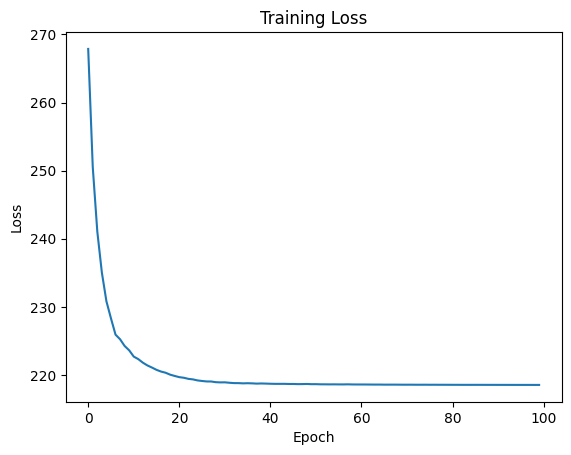

Model saved to models/gcrn_ip_dom1.pth


In [24]:

model_ip = GCRN_ip(input_dim, feature_dim, hidden_rec_dim, num_rec_layers)
print(model_ip)
print(f"Total number of trainable parameters: {model_ip.count_parameters()}")

train_model(model_ip, x_train, adj_train, num_epochs=100, lr=0.0001, save_path="models/gcrn_ip_dom1.pth")

#### Model with FFN Decoder

GCRN_ffn(
  (encoder): GCNEncoder(
    (conv1): GCN (16 -> 32)
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (32 -> 16)
    (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_mu): Linear(in_features=16, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=16, out_features=16, bias=True)
  )
  (decoder): FFNDecoder(
    (fc1): Linear(in_features=35, out_features=70, bias=True)
    (fc2): Linear(in_features=70, out_features=1225, bias=True)
  )
  (gru): GRU(16, 35, num_layers=2)
)
Total number of trainable parameters: 104332
Epoch 1, Loss: 213.1555046081543
Epoch 2, Loss: 189.78961591720582
Epoch 3, Loss: 130.70209233760835
Epoch 4, Loss: 43.74009485840797
Epoch 5, Loss: 14.17808776497841
Epoch 6, Loss: 9.892730504274368
Epoch 7, Loss: 9.147394922375678
Epoch 8, Loss: 8.78202061355114
Epoch 9, Loss: 7.295195558667183
Epoch 10, Loss: 7.838947531580925
Epoch 11, Loss: 6.6816

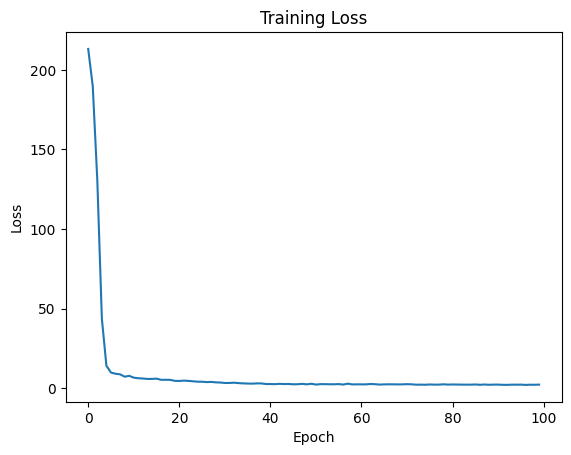

Model saved to models/gcrn_ffn_dom1.pth


In [26]:
model_ffn = GCRN_ffn(input_dim, feature_dim, hidden_rec_dim, num_rec_layers)
print(model_ffn)
print(f"Total number of trainable parameters: {model_ffn.count_parameters()}")

train_model(model_ffn, x_train, adj_train, num_epochs=100, lr=0.0001, save_path="models/gcrn_ffn_dom1.pth")

### Inference

In [103]:
# Define plot_heatmaps function if not already defined
def plot_heatmaps_each_timepoint(input_adj, ground_truth_adj, reconstructed_adj, residual_adj, time_point):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    ax[0].imshow(input_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[0].set_title(f'Input Graph at Time {time_point}')

    ax[1].imshow(ground_truth_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[1].set_title(f'Ground Truth Graph at Time {time_point+1}')

    ax[2].imshow(reconstructed_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[2].set_title(f'Generated Graph at Time {time_point+1}')

    ax[3].imshow(residual_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[3].set_title(f'Residual Graph at Time {time_point+1}')

    plt.show()

def plot_heatmaps_across_timepoints(input_adj, ground_truth_adj, reconstructed_adj, time_point):
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    cax0 = ax[0].imshow(input_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[0].set_title(f'Generated Graph at Time {time_point}')
    fig.colorbar(cax0, ax=ax[0])

    cax1 = ax[1].imshow(ground_truth_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[1].set_title(f'Generated Graph at Time {time_point+1}')
    fig.colorbar(cax1, ax=ax[1])

    cax2 = ax[2].imshow(reconstructed_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[2].set_title(f'Residual Graph between Time {time_point} and {time_point+1}')
    fig.colorbar(cax2, ax=ax[2])

    plt.show()

def inference_model(model, model_path, x, adj, sample_idx=0):
    # Load the saved model
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Perform inference
    with torch.no_grad():
        # Generate graph at time point 1 given graph at time point 0
        recon_adj_1, mu, logvar, _ = model(x[sample_idx, 0], adj[sample_idx, 0])
        residual_adj_1 = recon_adj_1 - adj[sample_idx, 1]
        plot_heatmaps_each_timepoint(adj[sample_idx, 0], adj[sample_idx, 1], recon_adj_1, residual_adj_1, 0)

        # Generate graph at time point 2 given graph at time point 1
        recon_adj_2, mu, logvar, _ = model(x[sample_idx, 1], adj[sample_idx, 1])
        residual_adj_2 = recon_adj_2 - adj[sample_idx, 2]
        plot_heatmaps_each_timepoint(adj[sample_idx, 1], adj[sample_idx, 2], recon_adj_2, residual_adj_2, 1)

        # Plot residual graph between the output of the first time point and the second time point
        residual_between_outputs = recon_adj_2 - recon_adj_1
        mse_residual_between_outputs = np.mean(np.square(residual_between_outputs.cpu().detach().numpy()))
        print("Mean Squared Error between graphs: ", mse_residual_between_outputs)
        plot_heatmaps_across_timepoints(recon_adj_1, recon_adj_2, residual_between_outputs, 1)

In [104]:
# Select a sample
sample_idx = 0

#### Model with GCN Decoder

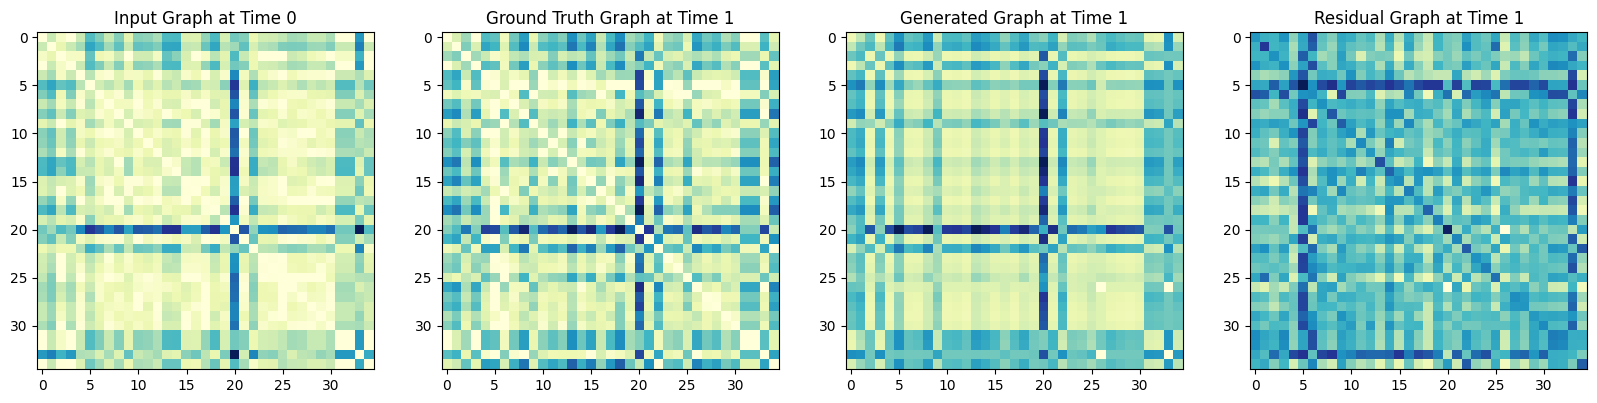

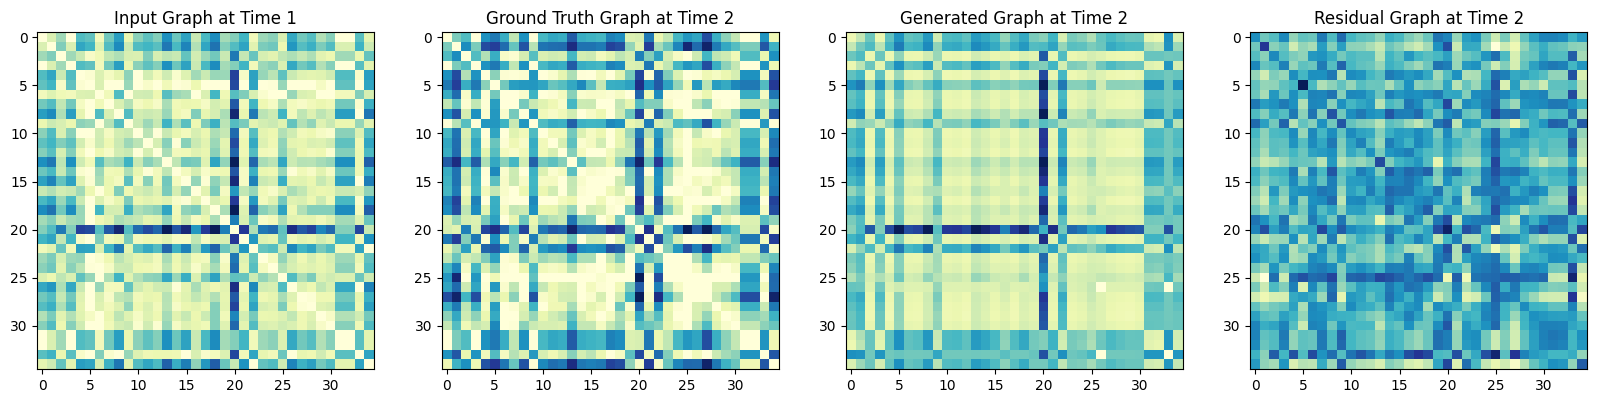

Mean Squared Error between graphs:  9.096006e-07


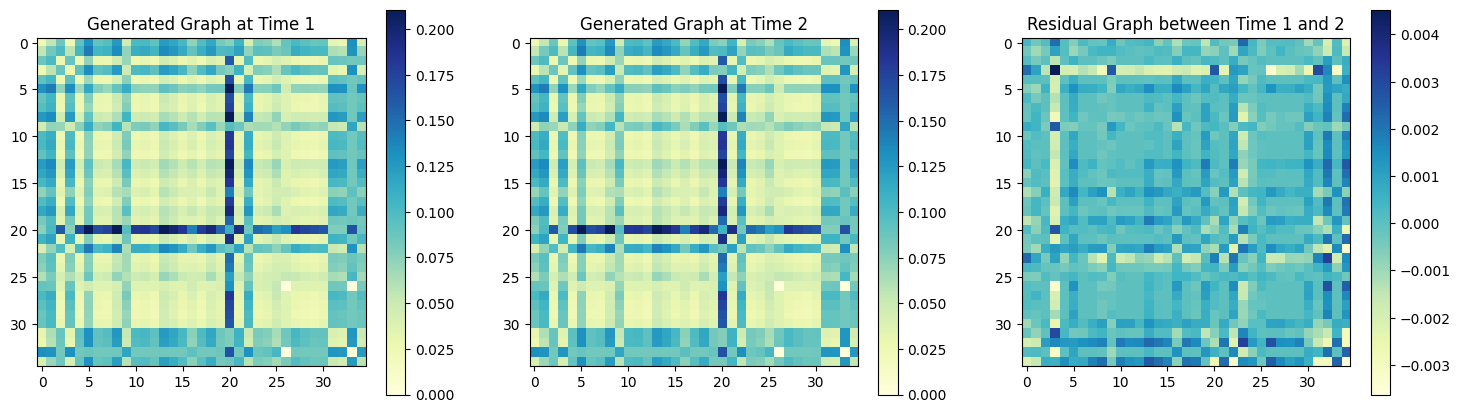

In [105]:
# Load the saved model
model_gcn = GCRN_gcn(input_dim, feature_dim, latent_dim, num_rec_layers)
model_gcn_path = 'models/gcrn_gcn_dom1.pth'
inference_model(model_gcn, model_gcn_path, x_train, adj_train, sample_idx)


### Inference of Other Decoders

#### Model with Inner Product Decoder

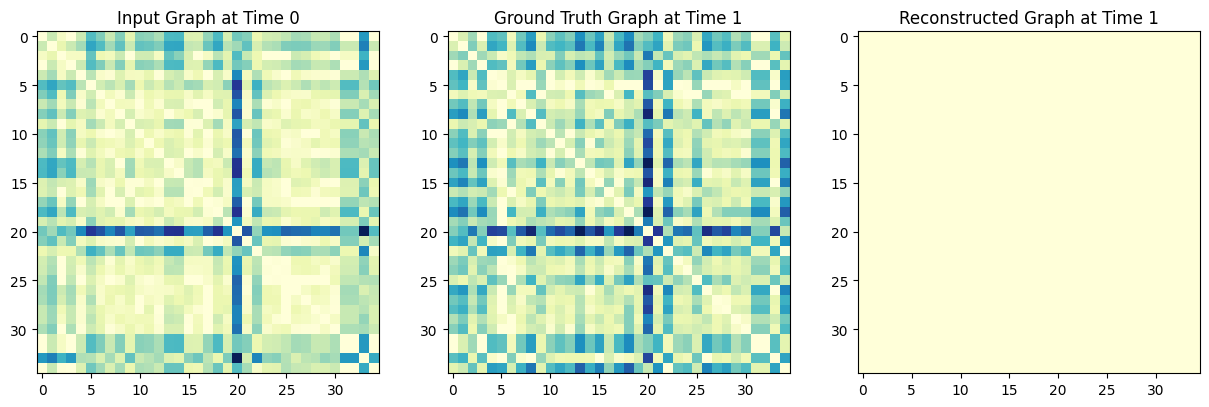

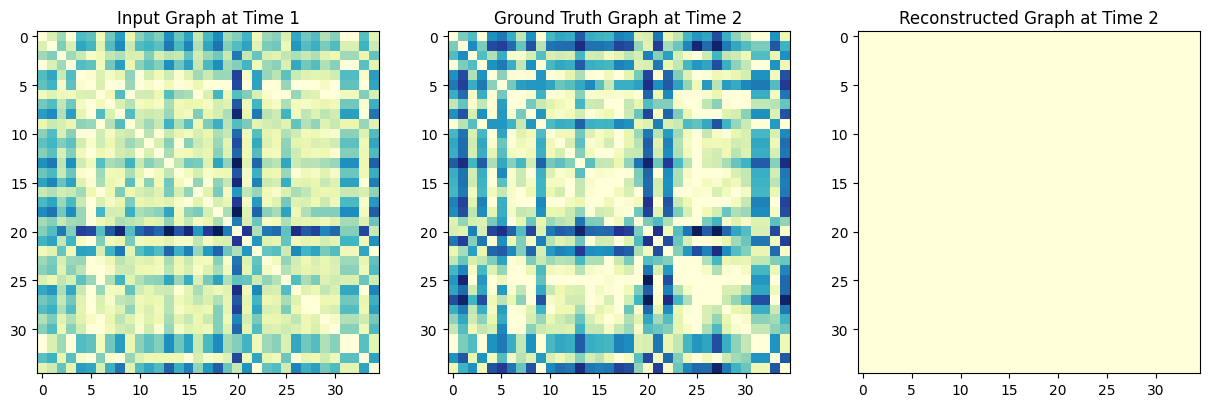

In [35]:
# Load the saved model
model_gcn = GCRN_ip(input_dim, feature_dim, hidden_rec_dim, num_rec_layers)
model_gcn_path = 'models/gcrn_ip_dom1.pth'
inference_model(model_gcn, model_gcn_path, x_train, adj_train, sample_idx)


#### Model with FFN Decoder

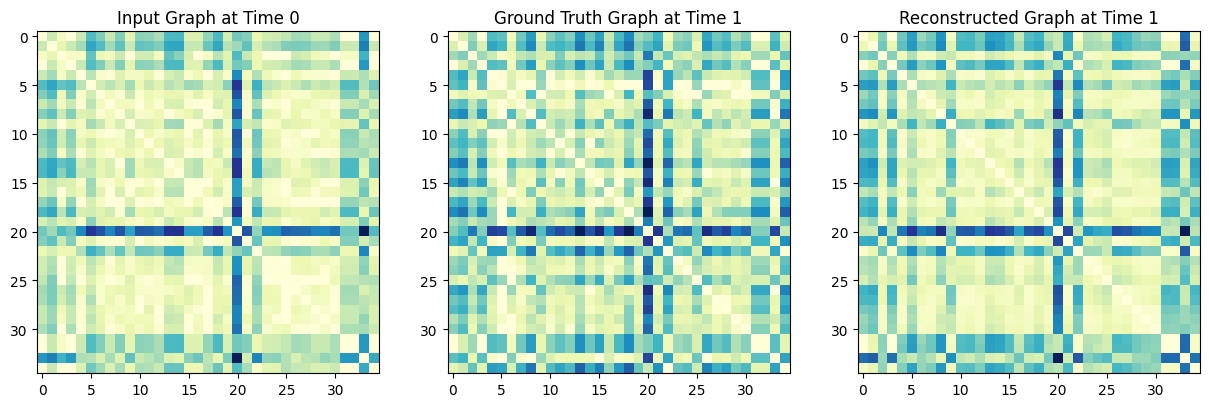

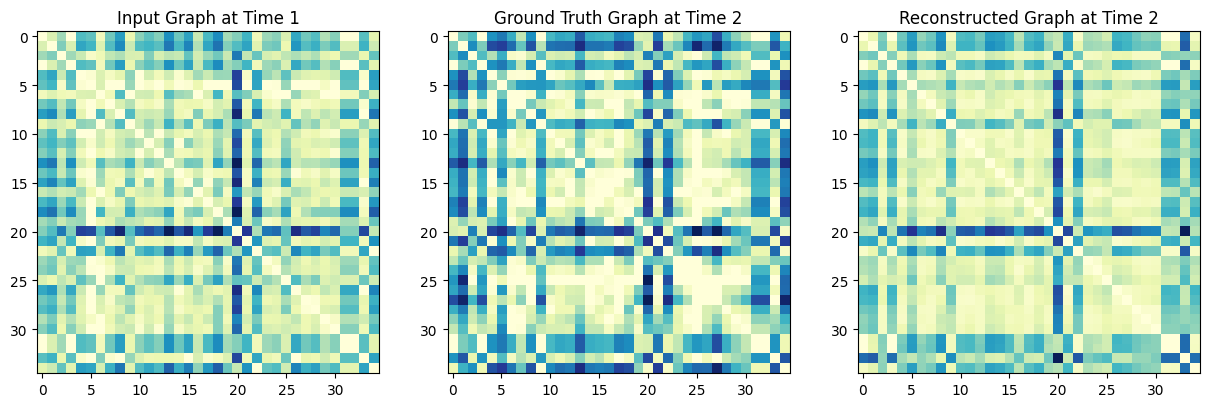

In [45]:
# Load the saved model
model_gcn = GCRN_ffn(input_dim, feature_dim, hidden_rec_dim, num_rec_layers)
model_gcn_path = 'models/gcrn_ffn_dom1.pth'
inference_model(model_gcn, model_gcn_path, x_train, adj_train, sample_idx)


### Evaluation

In [108]:
import networkx as nx
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon

def evaluate_model(model, x_test, adj_test):
    num_test_samples = x_test.shape[0]
    num_roi = adj_test.shape[2]

    # Initialize lists to store MAEs for each centrality measure
    mae_bc = []
    mae_ec = []
    mae_pc = []

    pred_1d_list = []
    gt_1d_list = []

    pred_matrices_all = []
    gt_matrices_all = []

    with torch.no_grad():
        for i in range(num_test_samples):
            for t in range(1, x_test.shape[1]):
                x_t = x_test[i, t-1]  # Node features at time point t-1
                adj_t = adj_test[i, t-1]  # Adjacency matrix at time point t-1
                
                # Predict adjacency matrix at time point t
                recon_adj_t, _, _, _ = model(x_t, adj_t)
                pred_matrices_all.append(recon_adj_t.cpu().numpy())
                
                adj_t_gt = adj_test[i, t]  # Ground truth adjacency matrix at time point t
                gt_matrices_all.append(adj_t_gt.cpu().numpy())

                # Convert adjacency matrices to NetworkX graphs
                pred_graph = nx.from_numpy_array(recon_adj_t.cpu().numpy(), edge_attr="weight")
                gt_graph = nx.from_numpy_array(adj_t_gt.cpu().numpy(), edge_attr="weight")

                # Compute centrality measures
                pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
                pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight")
                pred_pc = nx.pagerank(pred_graph, weight="weight")

                gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
                gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
                gt_pc = nx.pagerank(gt_graph, weight="weight")

                # Convert centrality dictionaries to lists
                pred_bc_values = list(pred_bc.values())
                pred_ec_values = list(pred_ec.values())
                pred_pc_values = list(pred_pc.values())

                gt_bc_values = list(gt_bc.values())
                gt_ec_values = list(gt_ec.values())
                gt_pc_values = list(gt_pc.values())

                # Compute MAEs
                mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
                mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
                mae_pc.append(mean_absolute_error(pred_pc_values, gt_pc_values))

                # Vectorize matrices
                pred_1d_list.append(vectorize(recon_adj_t.cpu().numpy()))
                gt_1d_list.append(vectorize(adj_t_gt.cpu().numpy()))

    # Compute average MAEs
    avg_mae_bc = sum(mae_bc) / len(mae_bc)
    avg_mae_ec = sum(mae_ec) / len(mae_ec)
    avg_mae_pc = sum(mae_pc) / len(mae_pc)

    # Concatenate flattened matrices
    pred_1d = np.concatenate(pred_1d_list)
    gt_1d = np.concatenate(gt_1d_list)

    # Compute metrics
    mae = mean_absolute_error(pred_1d, gt_1d)
    pcc = pearsonr(pred_1d, gt_1d)[0]
    js_dis = jensenshannon(pred_1d, gt_1d)

    print("MAE: ", mae)
    print("PCC: ", pcc)
    print("Jensen-Shannon Distance: ", js_dis)
    print("Average MAE betweenness centrality:", avg_mae_bc)
    print("Average MAE eigenvector centrality:", avg_mae_ec)
    print("Average MAE PageRank centrality:", avg_mae_pc)

    return mae, pcc, js_dis, avg_mae_bc, avg_mae_ec, avg_mae_pc

#### Model with GCN Decoder

In [111]:
model_gcn.eval()
# Evaluate the model
mae, pcc, js_dis, avg_mae_bc, avg_mae_ec, avg_mae_pc = evaluate_model(model_gcn, x_test, adj_test)


MAE:  0.034952838
PCC:  0.7757327589674246
Jensen-Shannon Distance:  0.200037610347269
Average MAE betweenness centrality: 0.07075963829057794
Average MAE eigenvector centrality: 0.01931527549844684
Average MAE PageRank centrality: 0.0035489144112607917


### Evaluation of Other Decoders

#### Model with Inner Product Decoder

MAE:  0.414956
PCC:  -0.015711872267093474
Jensen-Shannon Distance:  0.288300269618555
Average MAE betweenness centrality: 0.07129870129870128
Average MAE eigenvector centrality: 0.03709109803790815
Average MAE PageRank centrality: 0.007197019204628732


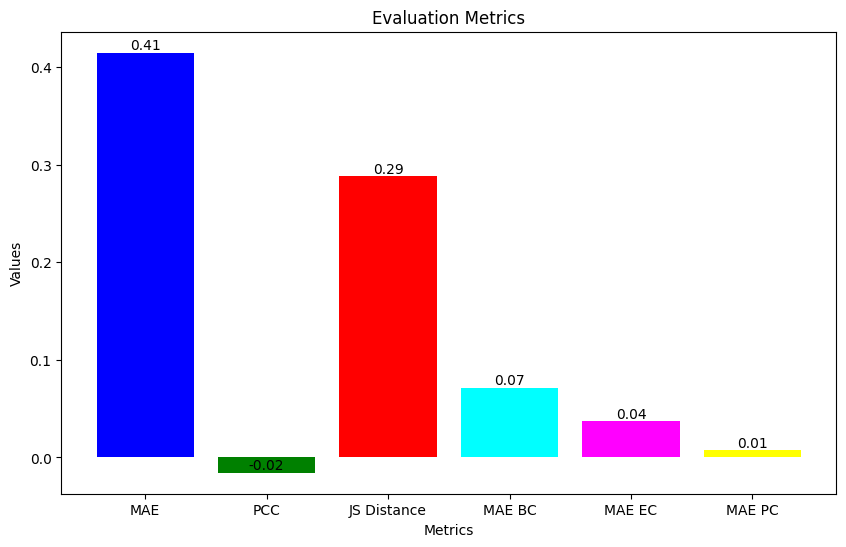

In [57]:
model_ip.eval()
# Evaluate the model
mae, pcc, js_dis, avg_mae_bc, avg_mae_ec, avg_mae_pc = evaluate_model(model_ip, x_test, adj_test)

#### Model with FFN Decoder

MAE:  0.028496407
PCC:  0.8178870717014904
Jensen-Shannon Distance:  0.17953148578731234
Average MAE betweenness centrality: 0.07477336389101094
Average MAE eigenvector centrality: 0.019134041424809546
Average MAE PageRank centrality: 0.00356549216218765


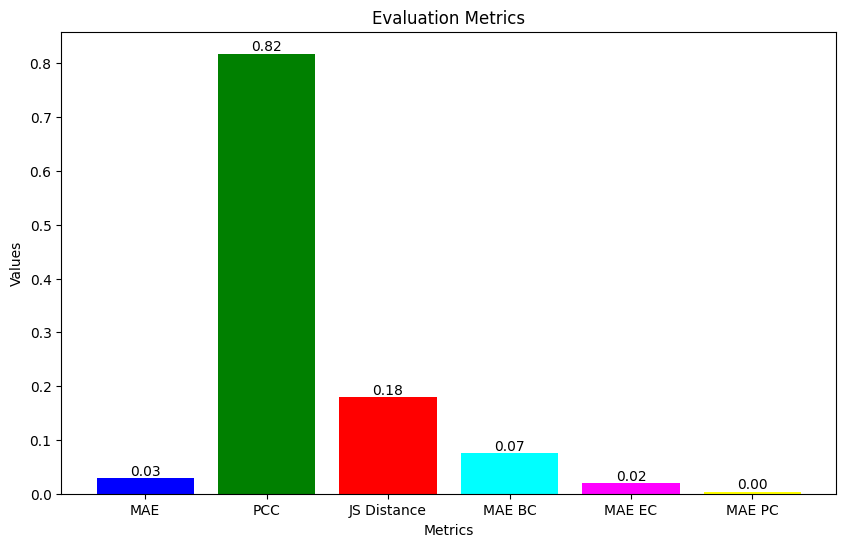

In [56]:
model_ffn.eval()
# Evaluate the model
mae, pcc, js_dis, avg_mae_bc, avg_mae_ec, avg_mae_pc = evaluate_model(model_ffn, x_test, adj_test)
